In [1]:
!pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 9.5 MB/s eta 0:00:00


In [2]:
!pip install -q portalocker>=2.0.0

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 🔴 **Import Libs**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torchtext
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import WikiText2

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split

from torch import optim
from torch.nn import functional as F

import tqdm
import torchmetrics as tm

import nltk
import re
from collections import Counter
import io

In [3]:
!python --version
print(torch.__version__)
print(torchtext.__version__)

Python 3.10.12
2.1.0+cu118
0.16.0+cpu


In [4]:
for lib in [np, torch, torchtext, tqdm, pd]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.23.5
torch --> 2.1.0+cu118
torchtext --> 0.16.0+cpu
tqdm --> 4.66.1
pandas --> 1.5.3


# 🔴 **Utils**

In [5]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [6]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

In [7]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# 🔴 **Dataset**

## 🟠 **Load the Dataset**

🔰 In this session you should load WikiText2 dataset.

In [8]:
!cp /content/drive/MyDrive/wikitext-2-v1.zip /content/

In [9]:
!unzip /content/wikitext-2-v1.zip

Archive:  /content/wikitext-2-v1.zip
   creating: wikitext-2/
  inflating: wikitext-2/wiki.test.tokens  
  inflating: wikitext-2/wiki.valid.tokens  
  inflating: wikitext-2/wiki.train.tokens  


In [10]:
with open('/content/wikitext-2/wiki.train.tokens', "r") as file:
    train_text = file.read()

with open('/content/wikitext-2/wiki.valid.tokens', "r") as file:
    valid_text = file.read()

with open('/content/wikitext-2/wiki.test.tokens', "r") as file:
    test_text = file.read()



In [11]:
train_iter, valid_iter, test_iter = WikiText2(root = '/content/')

In [12]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [13]:
train_sentences = nltk.sent_tokenize(train_text)
valid_sentences = nltk.sent_tokenize(valid_text)
test_sentences  = nltk.sent_tokenize(test_text)

In [14]:
len(train_sentences), len(valid_sentences), len(test_sentences)

(78353, 8224, 9608)

## 🟠 **Build vocabulary and save it**

🔰 In this section we need to:

*   Define a tokenizer using `basic_english`
*   Tokenize the dataset and collect tokens
*   Build the vocabulary using `build_vocab_from_iterator`
*   Manually insert special tokens and set the default index


In [15]:
tokenizer = get_tokenizer('basic_english')

In [16]:
train_tokens = tokenizer(train_text)
len(train_tokens)

2049990

In [17]:
word_counts = Counter()
for word in train_tokens:
    word_counts.update([word])

In [18]:
pd.DataFrame(word_counts.values(), index = word_counts.keys(), columns = ['N']).describe()

,N
count,28782.000000
mean,71.224724
std,1362.601628
min,3.000000
25%,4.000000
50%,8.000000
75%,23.000000
max,130768.000000


In [19]:
def yield_tokens(file_path):
    with io.open(file_path, encoding = 'utf-8') as f:
        for line in f:
            yield line.lower().strip().split()

In [20]:
vocabs  = build_vocab_from_iterator(map(tokenizer, train_iter), min_freq = 0, specials = ['<unk>'])
vocabs.set_default_index(vocabs['<unk>'])
vocabs.append_token('<eos>')
len(vocabs.get_itos())

28783

## 🟠 EDA

### 🟡 Let's explore the WikiText2 dataset!

### 🟡 Calculate basic statistics such as the number of documents, total words, average document length, etc.

In [21]:
l_sentences = []
for sentence in train_sentences:
  l_sentences.append(len(tokenizer(sentence)))

In [22]:
L_df = pd.DataFrame(l_sentences, index = train_sentences, columns = ['L'])

In [23]:
L_df.sort_values('L')

,L
!,1
.,1
.,1
.,1
?,1
...,...
"= = Filmography = = \n \n Cinta Pertama ( First Love ; 1973 ) ( awarded Citra FFI 1974 , <unk> ) \n <unk> ( <unk> ; 1974 ) \n <unk> <unk> ( Wedding Bed ; 1974 ) \n <unk> <unk> ( <unk> ; 1975 ) \n Si <unk> <unk> Modern ( <unk> the Modern Child ; 1976 ) \n Sesuatu yang Indah ( Something Beautiful ; 1977 ) ( awarded Citra FFI 1977 , Jakarta ) \n Badai Pasti Berlalu ( The Storm Will <unk> Pass ; 1977 ) \n <unk> @-@ <unk> ( Wanderers ; 1977 ) \n <unk> dan <unk> <unk> ( The <unk> and the <unk> Driver ; 1978 ) ( awarded Citra FFI 1979 , <unk> ) \n Dr. Siti <unk> ( 1980 ) \n <unk> <unk> , <unk> <unk> ( As White as the Heart , as Red as the <unk> ; 1982 ) \n Di <unk> <unk> ( Behind the Screen ; 1982 ) ( awarded Citra FFI 1983 , <unk> ) \n <unk> <unk> ( <unk> is <unk> ; 1984 ) \n Kerikil @-@ Kerikil <unk> ( Sharp <unk> ; 1984 ) ( awarded Citra FFI 1985 , Bandung ) \n Tjoet Nja ' Dhien ( 1988 ) ( awarded Citra FFI ) \n <unk> <unk> - Japan ( 1994 ) ( The Sleeping Man ; 1994 ) \n De <unk> van <unk> - Netherlands ( 1997 ) ( The <unk> of Emerald ; 1997 ) \n Daun di Atas Bantal ( Leaf on a <unk> ; 1998 ) \n Pasir Berbisik ( <unk> Sands ; 2001 ) \n <unk> ( Find <unk> ; 2009 ) \n <unk> dan Sang <unk> ( <unk> and the President ; 2009 ) \n Eat Pray Love ( 2010 ) \n Sang <unk> ( 2013 ) ( The <unk> ; 2013 ) \n <unk> <unk> <unk> ( 2014 ) ( The Golden Cane Warrior ; 2014 ) \n De <unk> - Netherlands ( Short ) ( 2014 ) ( The Journey ; 2014 ) \n Guru <unk> <unk> <unk> ( 2014 ) ( <unk> <unk> : <unk> of the People ; 2014 ) \n \n \n = A Month in the Country ( film ) = \n \n A Month in the Country is a 1987 British film directed by Pat O 'Connor .",335
"<unk> ed <unk> ; legate in Bologna \n <unk> <unk> ( September 26 , 1766 ) – Cardinal @-@ Priest of S. Maria in <unk> ; legate in <unk> \n Pietro <unk> ( September 26 , 1766 ) – Cardinal @-@ Priest of S. Maria in <unk> \n <unk> <unk> <unk> ( September 26 , 1766 ) – Cardinal @-@ Priest of S. Callisto ; archbishop of <unk> \n Filippo Maria Pirelli ( September 26 , 1766 ) – Cardinal @-@ Priest of S. <unk> \n Alessandro Albani ( July 16 , 1721 ) – Cardinal @-@ Deacon of S. Maria in Via <unk> ; <unk> of S. Maria in <unk> ; <unk> of the Sacred College of Cardinals ; <unk> of the Holy Roman Church ; Cardinal @-@ protector of Austria and the Kingdom of Sardinia \n <unk> Maria Corsini ( August 14 , 1730 ) – Cardinal @-@ Deacon of S. <unk> ; archpriest of the patriarchal Lateran Basilica ; secretary of the Supreme S.C. of the Roman and Universal Inquisition ; prefect of the Supreme Tribunal of the Apostolic Signature of Justice ; Cardinal @-@ protector of Portugal \n <unk> Orsini d <unk> ( September 9 , 1743 ) – Cardinal @-@ Deacon of S. Maria ad <unk> ; Cardinal @-@ protector of the Kingdom of Naples \n <unk> II Chigi ( November 26 , 1753 ) – Cardinal @-@ Deacon of S. Maria in <unk> ; prefect of the S.C. of <unk> \n Luigi Maria <unk> ( November 26 , 1753 ) – Cardinal @-@ Deacon of S. <unk> in <unk> ; Cardinal Secretary of State \n François @-@ Joachim de Pierre de Bernis ( October 2 , 1758 ) – Cardinal @-@ Deacon [ no <unk> assigned ] ; Cardinal @-@ protector of the Kingdom of France ; archbishop of <unk> \n Giovanni <unk> <unk> ( September 24 , 1759 ) – Cardinal @-@ Deacon of S. <unk> in <unk> ; prefect of the Tribunal of the Apostolic Signature of Grace \n Nicola <unk> ( September 24 , 1759 ) – Cardinal @-@ Deacon of S. <unk> in <unk> \n Andrea Corsini ( September 24 , 1759 ) – Cardinal @-@ Deacon of S. Angelo in <unk> \n Andrea <unk> ( July 18 , 1763 ) – Cardinal @-@ Deacon of SS .",376
"= = = Results of the ballots = = = \n \n The results of the ballots between April 27 and May 18 were following ( only the leading candidates are included ) : \n April 27 – Fantuzzi – 10 ; Colonna – 9 ; Pozzobonelli – 6 ; Stoppani – 5 ; Ganganelli – 5 \n April 28 – Fantuzzi – 9 ; Colonna – 9 ; Pozzobonelli – 7 ; Stoppani – 6 ; Ganganelli – 4 \n April 29 – Colonna – 11 ; Fantuzzi – 8 ; Stoppani – 5 ; P

In [24]:
L_df.describe()

,L
count,78353.000000
mean,26.163516
std,14.270514
min,1.000000
25%,17.000000
50%,24.000000
75%,33.000000
max,572.000000


In [25]:
L_df[L_df['L'] == 326]

,L


### 🟡 Analyze the most common and least common words in the dataset.

In [26]:
N_word = pd.DataFrame(word_counts.values(), index = word_counts.keys(), columns = ['N']).sort_values('N')
N_word[N_word['N']>4]

,N
pierced,5
kerch,5
drunken,5
imparted,5
italo,5
...,...
<unk>,54625
of,57030
.,83397
",",102615


In [27]:
N_word[N_word['N']>4].describe()

,N
count,20409.000000
mean,99.055711
std,1617.337605
min,5.000000
25%,7.000000
50%,14.000000
75%,37.000000
max,130768.000000


### 🟡  Please proceed with further exploration of the dataset. what do you suggest?

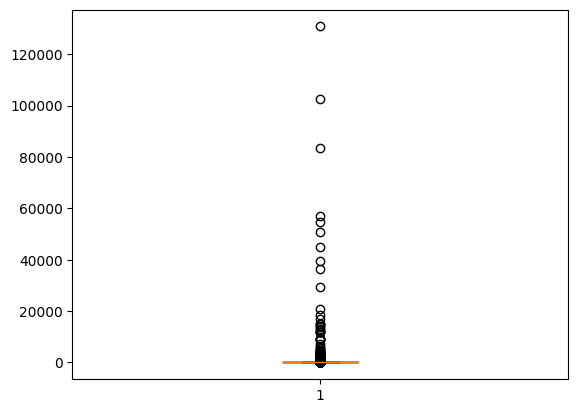

In [28]:
plt.boxplot(N_word[N_word['N']>4])
plt.show()

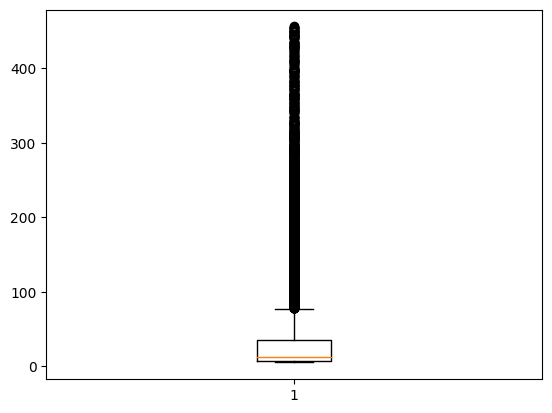

In [29]:
plt.boxplot(N_word[N_word['N']>4][0:20000])
plt.show()

In [30]:
len(N_word[N_word['N']>86]) #words that repeat over than mean

2502

## 🟠 Transform the data

🛑 Make sure to perform the transformations on train, validation and test datasets.

🔰 Reshape the dataset into an `N x B x L` or `M x L` format, where `N` represents the number of batches, `B` is the batch size, `L` is the length of a sample within each batch, and `M` is equal to `N x B`.

In [ ]:
def data_process(raw_text_iter, batch_size = 'auoto', seq_len = 350, tokenizer = None):

    tokens = tokenizer(raw_text_iter)

    n = int(len(tokens) / seq_len)

    if batch_size == 'auto' or batch_size == n:
      batch_size = int((len(tokens) - 1) / seq_len)
      print(f'{len(tokens) - batch_size * seq_len} token lost')

    else:
      if batch_size < n:
        print(f'{len(tokens) - batch_size * seq_len} token lost, set the batch_size = {n}')

      assert batch_size<=n, f'batch_size * seq_len = {batch_size * seq_len} but we have {len(tokens)} token, set the batch_size = {n}'

    inputs  = tokens[0 : batch_size * seq_len]
    targets = tokens[1 : batch_size * seq_len + 1]
    inputs  = np.array(inputs).reshape(batch_size, seq_len)
    targets = np.array(targets).reshape(batch_size, seq_len)

    return inputs, targets

In [ ]:
inputs, targets = data_process(train_text, 66512, 30, tokenizer)

54630 token lost, set the batch_size = 68333


In [ ]:
print(' '.join(inputs[3][0:10]))
print('   ' + ' '.join(targets[3][0:10]))

to the first game and follows the nameless , a
   the first game and follows the nameless , a penal


## 🟠 Transform the data2

🛑 Make sure to perform the transformations on train, validation and test datasets.

🔰 Reshape the dataset into an `N x B x L` or `M x L` format, where `N` represents the number of batches, `B` is the batch size, `L` is the length of a sample within each batch, and `M` is equal to `N x B`.

In [31]:
data = torch.cat([torch.LongTensor(vocabs(tokenizer(line)) + vocabs(['<eos>'])) for line in train_iter])

seq_len = 120
M = len(data) // seq_len

r = len(data) % seq_len
data = torch.cat((data, torch.LongTensor([0]))) if r==0 else data

inputs = data[:M*seq_len]
inputs = inputs.reshape(-1, seq_len)

targets = data[1:M*seq_len+1]
targets = targets.reshape(-1, seq_len)

inputs.shape, targets.shape

(torch.Size([17389, 120]), torch.Size([17389, 120]))

In [32]:
def data_process(raw_text_iter, seq_len):
  data = torch.cat([torch.LongTensor(vocabs(tokenizer(line)) + vocabs(['<eos>'])) for line in raw_text_iter])

  M = len(data) // seq_len

  r = len(data) % seq_len
  data = torch.cat((data, torch.LongTensor([0]))) if r==0 else data

  inputs = data[:M*seq_len]
  inputs = inputs.reshape(-1, seq_len)

  targets = data[1:M*seq_len+1]
  targets = targets.reshape(-1, seq_len)

  return inputs, targets

In [33]:
del data, inputs, targets

In [34]:
inputs, targets = data_process(train_iter, seq_len=65)
inputs.shape, targets.shape

(torch.Size([32103, 65]), torch.Size([32103, 65]))

In [35]:
seq_len = 70

X_train, y_train = data_process(train_iter, seq_len)
X_valid, y_valid = data_process(valid_iter, seq_len)
X_test, y_test = data_process(test_iter, seq_len)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

(torch.Size([29810, 70]),
 torch.Size([29810, 70]),
 torch.Size([3116, 70]),
 torch.Size([3116, 70]),
 torch.Size([3517, 70]),
 torch.Size([3517, 70]))

## 🟠 Custom dataset

🔰 Write a custom dataset class for LanguageModelDataset.

In [ ]:
class LanguageModelDataset(Dataset):

  def __init__(self, root, phase, vocabs, batch_size = 'auto', seq_len = 350, tokenizer = None):

    with open(root + f'wiki.{phase}.tokens', "r") as file:
        text = file.read()

    self.inputs, self.targets = data_process(text, batch_size, seq_len, tokenizer)
    self.vocabs = vocabs

  def __len__(self):
    return self.inputs.shape[0]

  def __getitem__(self, idx):

    input  = [self.vocabs[word] if word in self.vocabs else self.vocabs['<unk>'] for word in self.inputs[idx]]
    target = [self.vocabs[word] if word in self.vocabs else self.vocabs['<unk>'] for word in self.targets[idx]]
    #input  = list(map(lambda word: self.vocabs.get(word, self.vocabs['<ukn>']), self.inputs[idx]))
    #target = list(map(lambda word: self.vocabs.get(word, self.vocabs['<ukn>']), self.targets[idx]))

    input  = torch.LongTensor(input)
    target = torch.LongTensor(target)

    return input, target


In [ ]:
train_dataset = LanguageModelDataset('/content/wikitext-2/', 'train', vocabs, 'auto', 70, tokenizer)
valid_dataset = LanguageModelDataset('/content/wikitext-2/', 'valid', vocabs, 'auto', 70, tokenizer)
test_dataset  = LanguageModelDataset('/content/wikitext-2/', 'test' , vocabs, 'auto', 70, tokenizer)

40 token lost
7 token lost
9 token lost


In [ ]:
train_dataset[0]

(tensor([    9,  3849,  3869,   881,     9, 20000,    83,  3849,    88,     0,
          3869,    21,   780, 28780,     2,  6182,     3,  3849,     4,     1,
          5023,    88,    20,     2,  1837,  1018,     7,    14,  3849,  3869,
           881,   629,   976,     2,    23,     8,  5790,   299,    12,   575,
           232,    67,   452,    19, 13722,     5,   757,     3,  2500,    17,
             1,  1767,  5637,     3,   155,     6,   246,   354,     6,   976,
             2,    24,    23,     1,   237,    67,     6,     1,  3849,    93]),
 tensor([ 3849,  3869,   881,     9, 20000,    83,  3849,    88,     0,  3869,
            21,   780, 28780,     2,  6182,     3,  3849,     4,     1,  5023,
            88,    20,     2,  1837,  1018,     7,    14,  3849,  3869,   881,
           629,   976,     2,    23,     8,  5790,   299,    12,   575,   232,
            67,   452,    19, 13722,     5,   757,     3,  2500,    17,     1,
          1767,  5637,     3,   155,     6,   246,

## 🟠 Custom dataset 1

🔰 Write a custom dataset class for LanguageModelDataset.

In [36]:
class LanguageModelDataset(Dataset):

  def __init__(self, inputs, targets):
    self.inputs = inputs
    self.targets = targets

  def __len__(self):
    return self.inputs.shape[0]

  def __getitem__(self, idx):
    return self.inputs[idx], self.targets[idx]

In [37]:
train_dataset = LanguageModelDataset(X_train, y_train)
valid_dataset = LanguageModelDataset(X_valid, y_valid)
test_dataset = LanguageModelDataset(X_test, y_test)

In [38]:
train_dataset[0]

(tensor([28782,     9,  3849,  3869,   881,     9, 28782, 28782, 20000,    83,
          3849,    88,     0,  3869,    21,   780, 28780,     2,  6182,     3,
          3849,     4,     1,  5023,    88,    20,     2,  1837,  1018,     7,
            14,  3849,  3869,   881,   629,   976,     2,    23,     8,  5790,
           299,    12,   575,   232,    67,   452,    19, 13722,     5,   757,
             3,  2500,    17,     1,  1767,  5637,     3,   155,     6,   246,
           354,     6,   976,     2,    24,    23,     1,   237,    67,     6]),
 tensor([    9,  3849,  3869,   881,     9, 28782, 28782, 20000,    83,  3849,
            88,     0,  3869,    21,   780, 28780,     2,  6182,     3,  3849,
             4,     1,  5023,    88,    20,     2,  1837,  1018,     7,    14,
          3849,  3869,   881,   629,   976,     2,    23,     8,  5790,   299,
            12,   575,   232,    67,   452,    19, 13722,     5,   757,     3,
          2500,    17,     1,  1767,  5637,     3,

## 🟠 Define a dataloader if needed

🔰 Write dataloaders for the training, validation, and test sets.

In [39]:
set_seed(42)
train_loader = DataLoader(train_dataset, batch_size = 20, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size = 20, shuffle = False)
test_loader  = DataLoader(test_dataset,  batch_size = 20, shuffle = False)

In [40]:
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([20, 70]), torch.Size([20, 70]))

In [41]:
x, y = next(iter(valid_loader))
x.shape, y.shape

(torch.Size([20, 70]), torch.Size([20, 70]))

In [42]:
x, y = next(iter(test_loader))
x.shape, y.shape

(torch.Size([20, 70]), torch.Size([20, 70]))

# 🔴 **Model**

🔰 Use the following template to create a custom model.

Your model should consist of three parts:

*   an embedding layer
*   an LSTM layer
*   a fully connected layer

In [43]:
class LanguageModel(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, embedding_dropout, dropout_rate, bidirectional):
    super(LanguageModel, self).__init__()

    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    torch.nn.init.uniform_(self.embedding.weight, -0.1, 0.1)  # Initialize the weights

    self.lstm      = nn.LSTM(input_size = embedding_dim,
                             hidden_size = hidden_dim,
                             num_layers = num_layers,
                             batch_first = True,
                             bidirectional = bidirectional,
                             dropout = dropout_rate)

    self.dropout   = nn.Dropout(embedding_dropout)

    D = [2 if bidirectional == True else 1]

    self.cls      = nn.Linear(hidden_dim * D[0], vocab_size)

  def forward(self, src):

    embedded_src  = self.dropout(self.embedding(src))
    out, _        = self.lstm(embedded_src)
    out           = self.cls(out)

    return out


In [44]:
vocab_size = len(vocabs.get_stoi())
vocab_size

28783

In [45]:
model = LanguageModel(vocab_size, 50, 350, 2, 0.2, 0.5, False)

In [46]:
num_trainable_params(model.embedding), num_trainable_params(model.lstm), num_trainable_params(model.cls)

(1.43915, 1.5456, 10.102833)

In [47]:
num_trainable_params(model)

13.087583

In [48]:
ypred = model(x)
ypred.shape

torch.Size([20, 70, 28783])

In [49]:
nn.CrossEntropyLoss()(ypred.view(-1, ypred.size(-1)), y.view(-1))

tensor(10.2645, grad_fn=<NllLossBackward0>)

# 🔴 **Config**

In [50]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

🔰 Define the optimizer, loss function, metrics and other necessary parameters in this section, and ensure the model is sent to the appropriate device.

In [51]:
model = model.to(device)

In [52]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
loss_func = nn.CrossEntropyLoss()
metric    = tm.text.Perplexity().to(device)

# 🔴 **Train ➰**

🔰 This is the template for train function, change it if needed.

In [53]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=None):
  model.train()
  loss_train = AverageMeter()
  metric.reset()

  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs.view(-1, outputs.size(-1)), targets.view(-1))

      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      metric.update(outputs, targets)

      tepoch.set_postfix(loss=loss_train.avg, metric=metric.compute().item())

  return model, loss_train.avg, metric.compute().item()

# 🔴 **Evaluation**

🔰 This is the template for evaluation function, change it if needed.

In [54]:
def evaluate(model, data_loader, loss_fn, metric):
  model.eval()
  metric.reset()

  loss_valid = AverageMeter()

  for inputs, targets in data_loader:

    inputs = inputs.to(device)
    targets   = targets.to(device)

    with torch.no_grad():
      outputs = model(inputs)

    loss = loss_fn(outputs.view(-1, outputs.size(-1)), targets.view(-1))
    loss_valid.update(loss)
    metric.update(outputs, targets)

  print(f'Loss : {loss_valid.avg.item()}, Metric : {metric.compute().item()}')

  return loss_valid.avg.item(), metric.compute().item()

# 🔴 **Training Process 〽️**

## 🟠 Finding Hyper-parameters

*   List item
*   List item



### 🟡 **Step 1:** Calculate the loss for an untrained model using a few batches.


In [ ]:
model = LanguageModel(vocab_size, 256, 512, 2, 0.2, False).to(device)

inputs, targets = next(iter(train_loader))
inputs = inputs.to(device)
targets = targets.to(device)

with torch.no_grad():
  outputs = model(inputs)
  outputs = outputs.view(-1, outputs.size(-1))
  targets = targets.view(-1)
  loss = loss_func(outputs, targets)

print(loss)

tensor(10.2184, device='cuda:0')


### 🟡 **Step 2:** Try to train and overfit the model on a small subset of the

1.   List item
2.   List item

dataset.

In [ ]:
model = LanguageModel(vocab_size, 512, 256, 2, 0.2, False).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.5, momentum=0.9)

In [ ]:
num_trainable_params(model)

22.266221

In [ ]:
sub_set, _ = random_split(train_dataset, (100, len(train_dataset) - 100))
sub_loader = DataLoader(sub_set, batch_size = 2, shuffle = True)

In [ ]:
num_epochs = 20
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, sub_loader, loss_func, optimizer, metric, epoch)

Epoch 19: 100%|██████████| 50/50 [00:00<00:00, 67.51batch/s, loss=0.239, metric=1.27]


### 🟡 **Step 3:** Train the model for a limited number of epochs, experimenting with various learning rates.

In [ ]:
num_epochs = 5
lr_list    = [0.9, 0.5, 0.1, 0.01]
results    = []

for lr in lr_list:
  sub_result = []
  print(f'LR={lr}')

  model = LanguageModel(vocab_size, 512, 256, 2, 0.2, False).to(device)
  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=0, momentum=0.9)

  for epoch in range(num_epochs):
    model, train_loss, _ = train_one_epoch(model, train_loader, loss_func, optimizer, metric, epoch)

    if epoch == 0:
      sub_result.append(train_loss)
    if epoch == 4:
      sub_result.append(train_loss)

  results.append(sub_result)

  print()

LR=0.9


Epoch 4: 100%|██████████| 6834/6834 [02:04<00:00, 54.96batch/s, loss=4.51, metric=90.8]



LR=0.5


Epoch 4: 100%|██████████| 6834/6834 [02:03<00:00, 55.25batch/s, loss=4.45, metric=85.8]



LR=0.1


Epoch 4: 100%|██████████| 6834/6834 [02:03<00:00, 55.49batch/s, loss=4.62, metric=102]



LR=0.01


Epoch 4: 100%|██████████| 6834/6834 [02:03<00:00, 55.29batch/s, loss=5.3, metric=200]

In [ ]:
pd.DataFrame(results, columns = ['start', 'stop'], index = lr_list)

,start,stop
0.90,5.230411,4.508571
0.50,5.238649,4.451442
0.10,5.487728,4.620991
0.01,6.195638,5.296711


### 🟡 Step 4: Create a small grid using the weight decay and the best learning rate.





In [ ]:
lr_list = [0.5, 0.6]
wd_list = [0, 1e-4, 1e-5, 1e-6]
result  = []
indexes = []

for lr in lr_list:
  for wd in wd_list:

    print(f'LR = {lr}, Weight_decay = {wd}')
    indexes.append(f'LR = {lr}, Weight_decay = {wd}')

    sub_result = []

    model = LanguageModel(vocab_size, 512, 256, 2, 0.2, False).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum = 0.9, weight_decay = wd)
    loss_func = torch.nn.CrossEntropyLoss()
    metric    = tm.text.Perplexity().to(device)

    for i in range(5):
      model, train_loss, metric_train = train_one_epoch(model, train_loader, loss_func, optimizer, metric, i)
      valid_loss, metric_valid        = evaluate(model, valid_loader, loss_func, metric)

      if i == 0:
        sub_result.append(train_loss)
        sub_result.append(valid_loss)
      if i == 4:
        sub_result.append(train_loss)
        sub_result.append(valid_loss)

    result.append(sub_result)
    torch.save(model, f'/content/models-step4/model*{lr}*{wd}.pt')
    print('model saved!')
    print('---------------------------------------------')

LR = 0.5, Weight_decay = 0


Epoch 0: 100%|██████████| 6834/6834 [02:04<00:00, 54.83batch/s, loss=5.23, metric=187]


Loss : 4.837555408477783, Metric : 126.1761474609375


Epoch 1: 100%|██████████| 6834/6834 [02:06<00:00, 53.89batch/s, loss=4.79, metric=120]


Loss : 4.684847831726074, Metric : 108.30665588378906


Epoch 2: 100%|██████████| 6834/6834 [02:02<00:00, 55.61batch/s, loss=4.62, metric=102]


Loss : 4.631700038909912, Metric : 102.70396423339844


Epoch 3: 100%|██████████| 6834/6834 [02:01<00:00, 56.18batch/s, loss=4.52, metric=92]


Loss : 4.593882083892822, Metric : 98.89139556884766


Epoch 4: 100%|██████████| 6834/6834 [02:01<00:00, 56.34batch/s, loss=4.45, metric=85.3]


Loss : 4.572687149047852, Metric : 96.81759643554688
model saved!
---------------------------------------------
LR = 0.5, Weight_decay = 0.0001


Epoch 0: 100%|██████████| 6834/6834 [02:08<00:00, 53.17batch/s, loss=5.42, metric=225]


Loss : 5.1397833824157715, Metric : 170.7039337158203


Epoch 1: 100%|██████████| 6834/6834 [02:09<00:00, 52.59batch/s, loss=5.17, metric=176]


Loss : 5.073412895202637, Metric : 159.73944091796875


Epoch 2: 100%|██████████| 6834/6834 [02:09<00:00, 52.64batch/s, loss=5.13, metric=169]


Loss : 5.034902572631836, Metric : 153.69949340820312


Epoch 3: 100%|██████████| 6834/6834 [02:10<00:00, 52.21batch/s, loss=5.12, metric=167]


Loss : 5.055343151092529, Metric : 156.87188720703125


Epoch 4: 100%|██████████| 6834/6834 [02:10<00:00, 52.30batch/s, loss=5.1, metric=165]


Loss : 5.046222686767578, Metric : 155.44461059570312
model saved!
---------------------------------------------
LR = 0.5, Weight_decay = 1e-05


Epoch 0: 100%|██████████| 6834/6834 [02:10<00:00, 52.24batch/s, loss=5.24, metric=189]


Loss : 4.887879371643066, Metric : 132.68824768066406


Epoch 1: 100%|██████████| 6834/6834 [02:10<00:00, 52.35batch/s, loss=4.81, metric=123]


Loss : 4.709513187408447, Metric : 111.01516723632812


Epoch 2: 100%|██████████| 6834/6834 [02:10<00:00, 52.53batch/s, loss=4.65, metric=105]


Loss : 4.636446952819824, Metric : 103.19058227539062


Epoch 3: 100%|██████████| 6834/6834 [02:10<00:00, 52.52batch/s, loss=4.56, metric=95.5]


Loss : 4.608745574951172, Metric : 100.3690414428711


Epoch 4: 100%|██████████| 6834/6834 [02:09<00:00, 52.61batch/s, loss=4.49, metric=88.9]


Loss : 4.552745342254639, Metric : 94.90645599365234
model saved!
---------------------------------------------
LR = 0.5, Weight_decay = 1e-06


Epoch 0: 100%|██████████| 6834/6834 [02:09<00:00, 52.82batch/s, loss=5.23, metric=188]


Loss : 4.842280387878418, Metric : 126.77567291259766


Epoch 1: 100%|██████████| 6834/6834 [02:09<00:00, 52.75batch/s, loss=4.79, metric=120]


Loss : 4.6929240226745605, Metric : 109.1874008178711


Epoch 2: 100%|██████████| 6834/6834 [02:09<00:00, 52.74batch/s, loss=4.62, metric=102]


Loss : 4.624514579772949, Metric : 101.9654769897461


Epoch 3: 100%|██████████| 6834/6834 [02:10<00:00, 52.42batch/s, loss=4.52, metric=91.7]


Loss : 4.5915679931640625, Metric : 98.65782928466797


Epoch 4: 100%|██████████| 6834/6834 [02:10<00:00, 52.50batch/s, loss=4.44, metric=84.8]


Loss : 4.565415382385254, Metric : 96.1138687133789
model saved!
---------------------------------------------
LR = 0.6, Weight_decay = 0


Epoch 0: 100%|██████████| 6834/6834 [02:03<00:00, 55.18batch/s, loss=5.23, metric=187]


Loss : 4.8350911140441895, Metric : 125.86534881591797


Epoch 1: 100%|██████████| 6834/6834 [02:03<00:00, 55.18batch/s, loss=4.79, metric=121]


Loss : 4.710006237030029, Metric : 111.07356262207031


Epoch 2: 100%|██████████| 6834/6834 [02:04<00:00, 54.89batch/s, loss=4.64, metric=103]


Loss : 4.643154144287109, Metric : 103.88251495361328


Epoch 3: 100%|██████████| 6834/6834 [02:04<00:00, 55.03batch/s, loss=4.54, metric=93.3]


Loss : 4.607339382171631, Metric : 100.22967529296875


Epoch 4: 100%|██████████| 6834/6834 [02:05<00:00, 54.58batch/s, loss=4.46, metric=86.8]


Loss : 4.608919143676758, Metric : 100.38909912109375
model saved!
---------------------------------------------
LR = 0.6, Weight_decay = 0.0001


Epoch 0: 100%|██████████| 6834/6834 [02:12<00:00, 51.75batch/s, loss=5.42, metric=227]


Loss : 5.144461631774902, Metric : 171.501953125


Epoch 1: 100%|██████████| 6834/6834 [02:10<00:00, 52.27batch/s, loss=5.2, metric=182]


Loss : 5.12229061126709, Metric : 167.74053955078125


Epoch 2: 100%|██████████| 6834/6834 [02:10<00:00, 52.20batch/s, loss=5.17, metric=176]


Loss : 5.077136516571045, Metric : 160.3328399658203


Epoch 3: 100%|██████████| 6834/6834 [02:11<00:00, 52.05batch/s, loss=5.16, metric=174]


Loss : 5.064982891082764, Metric : 158.3984375


Epoch 4: 100%|██████████| 6834/6834 [02:12<00:00, 51.70batch/s, loss=5.15, metric=173]


Loss : 5.078039169311523, Metric : 160.47341918945312
model saved!
---------------------------------------------
LR = 0.6, Weight_decay = 1e-05


Epoch 0: 100%|██████████| 6834/6834 [02:11<00:00, 51.93batch/s, loss=5.25, metric=191]


Loss : 4.854742527008057, Metric : 128.36331176757812


Epoch 1: 100%|██████████| 6834/6834 [02:11<00:00, 52.07batch/s, loss=4.83, metric=125]


Loss : 4.715738773345947, Metric : 111.70291137695312


Epoch 2: 100%|██████████| 6834/6834 [02:11<00:00, 52.16batch/s, loss=4.67, metric=107]


Loss : 4.659645080566406, Metric : 105.61224365234375


Epoch 3: 100%|██████████| 6834/6834 [02:10<00:00, 52.21batch/s, loss=4.58, metric=97.3]


Loss : 4.614287853240967, Metric : 100.92849731445312


Epoch 4: 100%|██████████| 6834/6834 [02:10<00:00, 52.32batch/s, loss=4.51, metric=90.6]


Loss : 4.552901744842529, Metric : 94.91790008544922
model saved!
---------------------------------------------
LR = 0.6, Weight_decay = 1e-06


Epoch 0: 100%|██████████| 6834/6834 [02:10<00:00, 52.40batch/s, loss=5.23, metric=187]


Loss : 4.841360569000244, Metric : 126.65699768066406


Epoch 1: 100%|██████████| 6834/6834 [02:09<00:00, 52.57batch/s, loss=4.8, metric=121]


Loss : 4.71036958694458, Metric : 111.10905456542969


Epoch 2: 100%|██████████| 6834/6834 [02:10<00:00, 52.33batch/s, loss=4.64, metric=103]


Loss : 4.629836082458496, Metric : 102.51260375976562


Epoch 3: 100%|██████████| 6834/6834 [02:10<00:00, 52.26batch/s, loss=4.53, metric=93]


Loss : 4.613683223724365, Metric : 100.86932373046875


Epoch 4: 100%|██████████| 6834/6834 [02:11<00:00, 51.81batch/s, loss=4.46, metric=86.1]


Loss : 4.570570945739746, Metric : 96.61454772949219
model saved!
---------------------------------------------


In [ ]:
pd.DataFrame(result, index = indexes, columns = ['start train loss', 'start valid loss', 'stop train loss', 'stop valid loss'])

,start train loss,start valid loss,stop train loss,stop valid loss
"LR = 0.5, Weight_decay = 0",5.230556,4.837555,4.446719,4.572687
"LR = 0.5, Weight_decay = 0.0001",5.417839,5.139783,5.104489,5.046223
"LR = 0.5, Weight_decay = 1e-05",5.243723,4.887879,4.487812,4.552745
"LR = 0.5, Weight_decay = 1e-06",5.234023,4.842280,4.440844,4.565415
"LR = 0.6, Weight_decay = 0",5.230816,4.835091,4.464052,4.608919
"LR = 0.6, Weight_decay = 0.0001",5.422848,5.144462,5.150514,5.078039
"LR = 0.6, Weight_decay = 1e-05",5.254499,4.854743,4.506000,4.552902
"LR = 0.6, Weight_decay = 1e-06",5.229013,4.841361,4.455349,4.570571


### 🟡 Step 5: Train model for longer epochs using the best model from step 4.





In [ ]:
model = torch.load('/content/models-step4/model*0.5*1e-06.pt').to(device)

In [ ]:
lr = 0.5
wd = 1e-6
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
metric    = tm.text.Perplexity().to(device)
loss_func = nn.CrossEntropyLoss()

In [ ]:
start, stop = 0, 10
for  epoch in range(start, stop):
  model, _, _ = train_one_epoch(model, train_loader, loss_func, optimizer, metric, epoch)
  _, _        = evaluate(model, valid_loader, loss_func, metric)

Epoch 0: 100%|██████████| 6834/6834 [02:09<00:00, 52.72batch/s, loss=4.38, metric=79.5]


Loss : 4.553989887237549, Metric : 95.02405548095703


Epoch 1: 100%|██████████| 6834/6834 [02:10<00:00, 52.23batch/s, loss=4.32, metric=75.5]


Loss : 4.545749664306641, Metric : 94.2418212890625


Epoch 2: 100%|██████████| 6834/6834 [02:12<00:00, 51.42batch/s, loss=4.28, metric=72.2]


Loss : 4.545175075531006, Metric : 94.19034576416016


Epoch 3: 100%|██████████| 6834/6834 [02:10<00:00, 52.41batch/s, loss=4.24, metric=69.5]


Loss : 4.53021240234375, Metric : 92.79459381103516


Epoch 4: 100%|██████████| 6834/6834 [02:11<00:00, 52.13batch/s, loss=4.2, metric=67]


Loss : 4.528470516204834, Metric : 92.6327896118164


Epoch 5: 100%|██████████| 6834/6834 [02:11<00:00, 52.08batch/s, loss=4.17, metric=64.9]


Loss : 4.5377197265625, Metric : 93.49175262451172


Epoch 6: 100%|██████████| 6834/6834 [02:10<00:00, 52.20batch/s, loss=4.14, metric=63]


Loss : 4.533679485321045, Metric : 93.11256408691406


Epoch 7: 100%|██████████| 6834/6834 [02:10<00:00, 52.26batch/s, loss=4.12, metric=61.3]


Loss : 4.522038459777832, Metric : 92.03730010986328


Epoch 8: 100%|██████████| 6834/6834 [02:09<00:00, 52.80batch/s, loss=4.09, metric=59.8]


Loss : 4.522080898284912, Metric : 92.04002380371094


Epoch 9: 100%|██████████| 6834/6834 [02:09<00:00, 52.83batch/s, loss=4.07, metric=58.4]


Loss : 4.521821022033691, Metric : 92.01790618896484


## 🟠 Main Loop

🔰 Define model.

In [ ]:
torch.cuda.empty_cache()

In [ ]:
model = LanguageModel(vocab_size, 400, 380, 2, 0.5, 0.2, False).to(device)
num_trainable_params(model)

24.825622

🔰 Define optimizer and Set learning rate and weight decay.

In [ ]:
train_loss_hist, valid_loss_hist = [], []
train_metric_hist, valid_metric_hist = [], []
best_metric = torch.inf

In [ ]:
lr = 1.6
wd = 1e-6
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr = lr, betas = [0.9, 0.99])
loss_func = nn.CrossEntropyLoss()
metric    = tm.text.Perplexity().to(device)

🔰 Write code to train the model for `num_epochs` epoches.

In [ ]:
start, stop = 35, 40
wait = 0
for  epoch in range(start, stop):
  model, train_loss, metric_train = train_one_epoch(model, train_loader, loss_func, optimizer, metric, epoch)
  valid_loss, metric_valid        = evaluate(model, valid_loader, loss_func, metric)

  train_loss_hist.append(train_loss)
  train_metric_hist.append(metric_train)
  valid_loss_hist.append(valid_loss)
  valid_metric_hist.append(metric_valid)

  if metric_valid<best_metric:
    wait = 0

    best_metric = metric_valid

    torch.save(model, 'best_model.pt')
    print('model saved!')
  else:
    wait += 1
    if wait == 1:
      wait = 0
      model = torch.load('/content/best_model.pt').to(device)
      lr = 0.6 * lr
      optimizer = optim.SGD(model.parameters(), lr = lr, momentum = 0.9, weight_decay = wd)
      print(f'Change learning rate = {lr}')

Epoch 35: 100%|██████████| 5858/5858 [02:20<00:00, 41.76batch/s, loss=3.87, metric=47.9]


Loss : 4.859670639038086, Metric : 129.01512145996094
Change learning rate = 0.07464959999999998


Epoch 36: 100%|██████████| 5858/5858 [02:19<00:00, 41.97batch/s, loss=3.86, metric=47.3]


Loss : 4.855729103088379, Metric : 128.50662231445312
Change learning rate = 0.04478975999999999


Epoch 37: 100%|██████████| 5858/5858 [02:19<00:00, 41.99batch/s, loss=3.85, metric=46.9]


Loss : 4.856640815734863, Metric : 128.62388610839844
Change learning rate = 0.026873855999999995


Epoch 38: 100%|██████████| 5858/5858 [02:19<00:00, 41.92batch/s, loss=3.84, metric=46.7]


Loss : 4.856374263763428, Metric : 128.5896759033203
Change learning rate = 0.016124313599999995


Epoch 39: 100%|██████████| 5858/5858 [02:19<00:00, 41.98batch/s, loss=3.84, metric=46.6]


Loss : 4.8554863929748535, Metric : 128.47610473632812
Change learning rate = 0.009674588159999997


## 🟠 Plot

🔰 Plot learning curves

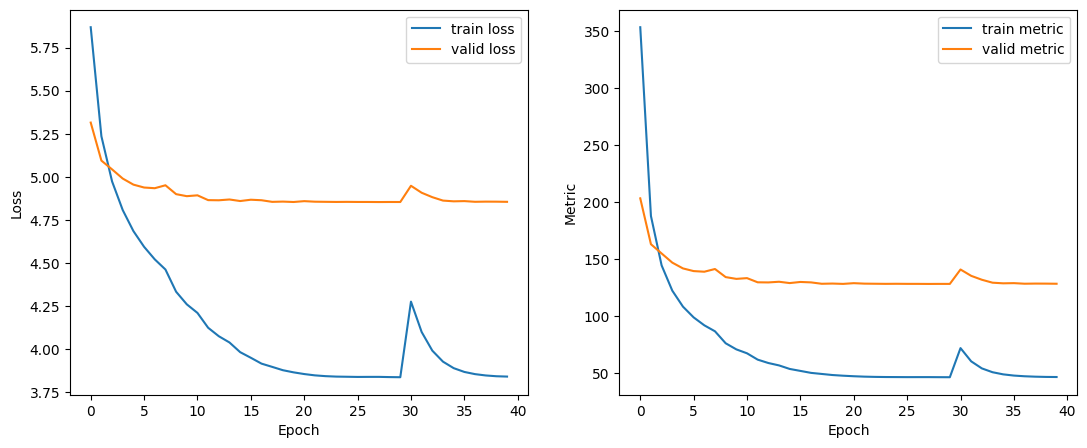

In [ ]:
plt.figure(figsize = (13, 5))
plt.subplot(1, 2, 1)
plt.plot(range(0, stop), train_loss_hist, label = 'train loss')
plt.plot(range(0, stop), valid_loss_hist, label = 'valid loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(range(0, stop), train_metric_hist, label = 'train metric')
plt.plot(range(0, stop), valid_metric_hist, label = 'valid metric')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.show()

In [ ]:
min(valid_metric_hist)

128.3133087158203

# 🔴 **Test**

🔰 Test your model using data from the test set

In [ ]:
model = torch.load('/content/best_model.pt').eval()

In [ ]:
with torch.no_grad():
  _, _ = evaluate(model, test_loader, loss_func, metric)

Loss : 4.801955699920654, Metric : 121.74787902832031


# 🔴 **Generate**

🔰 Your mission is to write a `generate` function and use a desired sentence to evaluate the model

In [ ]:
model = torch.load('/content/best_model.pt').eval()

In [ ]:
def generate(prompt, max_seq_len, temperature, model, tokenizer, vocab, seed=None):
  tokenized_text = tokenizer(prompt)
  indexed_text   = torch.tensor([vocab[token] if token in vocab else vocab['<ukn>'] for token in tokenized_text])
  counter = 0
  generated_text = indexed_text
  max_seq_len    = max_seq_len - len(tokenized_text)
  while(counter<max_seq_len):
    with torch.no_grad():
      out = model(generated_text.to(device))[-1]

    out_softmax    = torch.nn.functional.softmax(out/temperature, dim = -1)
    multino_out    = torch.multinomial(torch.tensor(out_softmax), 1).item()

    if multino_out == vocab['<unk>']:
      None
    elif multino_out == vocab['.'] or counter == max_seq_len - 1:
      d = generated_text.tolist()
      d.append(vocab['.'])
      generated_text = torch.tensor(d)
      counter  = max_seq_len
    else:
      d = generated_text.tolist()
      d.append(multino_out)
      generated_text = torch.tensor(d)
      counter        += 1

  return ' '.join([vocab.get_itos()[index] if index in vocab.get_stoi().values() else '<not>' for index in generated_text.tolist()])

In [ ]:
text = 'in the same time'
p = generate(text, 50, 0.8, model, tokenizer, vocabs)
p

<ipython-input-67-3986dce9587c>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  multino_out    = torch.multinomial(torch.tensor(out_softmax), 1).item()


"in the same time as a television network , the cbs dubbed the sequel a thriller special sung by ken gibson , who was cast as the film ' s script , and the project continued as a commercial organizer and spends more time , the script was split ."

In [ ]:
text = 'in this year'
p = generate(text, 50, 0.5, model, tokenizer, vocabs)
p

<ipython-input-67-3986dce9587c>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  multino_out    = torch.multinomial(torch.tensor(out_softmax), 1).item()


"in this year , as he was in the first game of the season , and he was named the team ' s captain ."

In [ ]:
text = 'This recommended approach helps prevent potential issues related to computational graph tracking'
p = generate(text, 17, 0.8, model, tokenizer, vocabs)
p

<ipython-input-67-3986dce9587c>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  multino_out    = torch.multinomial(torch.tensor(out_softmax), 1).item()


'this recommended approach helps prevent potential issues related to computational graph tracking from the blocked earth .'

In [ ]:
text = 'I think the movie'
p = generate(text, 50, 0.8, model, tokenizer, vocabs)
p

<ipython-input-67-3986dce9587c>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  multino_out    = torch.multinomial(torch.tensor(out_softmax), 1).item()


'i think the movie was good .'

# 🔵 **Methods function**

In [55]:
import torch
from torch.nn import Parameter
from functools import wraps

class WeightDrop(torch.nn.Module):
    def __init__(self, module, weights, dropout=0, variational=False):
        super(WeightDrop, self).__init__()
        self.module = module
        self.weights = weights
        self.dropout = dropout
        self.variational = variational
        self._setup()

    def widget_demagnetizer_y2k_edition(*args, **kwargs):
        # We need to replace flatten_parameters with a nothing function
        # It must be a function rather than a lambda as otherwise pickling explodes
        # We can't write boring code though, so ... WIDGET DEMAGNETIZER Y2K EDITION!
        # (╯°□°）╯︵ ┻━┻
        return

    def _setup(self):
        # Terrible temporary solution to an issue regarding compacting weights re: CUDNN RNN
        if issubclass(type(self.module), torch.nn.RNNBase):
            self.module.flatten_parameters = self.widget_demagnetizer_y2k_edition

        for name_w in self.weights:
            print('Applying weight drop of {} to {}'.format(self.dropout, name_w))
            w = getattr(self.module, name_w)
            del self.module._parameters[name_w]
            self.module.register_parameter(name_w + '_raw', Parameter(w.data))

    def _setweights(self):
        for name_w in self.weights:
            raw_w = getattr(self.module, name_w + '_raw')
            w = None
            if self.variational:
                mask = torch.autograd.Variable(torch.ones(raw_w.size(0), 1))
                if raw_w.is_cuda: mask = mask.cuda()
                mask = torch.nn.functional.dropout(mask, p=self.dropout, training=True)
                w = mask.expand_as(raw_w) * raw_w
            else:
                w = torch.nn.functional.dropout(raw_w, p=self.dropout, training=self.training)
            #setattr(self.module, name_w, w)
            setattr(self.module, name_w, torch.nn.Parameter(w))

    def forward(self, *args):
        self._setweights()
        return self.module.forward(*args)

In [56]:
class NTASGD(optim.Optimizer):
    def __init__(self, params, lr=1, n=5, weight_decay=0, fine_tuning=False):
        t0 = 0 if fine_tuning else 10e7
        defaults = dict(lr=lr, n=n, weight_decay=weight_decay, fine_tuning=fine_tuning, t0=t0, t=0, logs=[])
        super(NTASGD, self).__init__(params, defaults)

    def check(self, v):
        for group in self.param_groups:
            #Training
            if (not group['fine_tuning'] and group['t0'] == 10e7) or (group['fine_tuning']):
                if group['t'] > group['n'] and v > min(group['logs'][:-group['n']]):
                    group['t0'] = self.state[next(iter(group['params']))]['step']
                    print("Non-monotonic condition is triggered!")
                    return True
                group['logs'].append(v)
                group['t'] += 1

    def lr(self, lr):
        for group in self.param_groups:
            group['lr'] = lr

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
              if p.grad is not None:
                grad = p.grad.data
                state = self.state[p]
                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    state['mu'] = 1
                    state['ax'] = torch.zeros_like(p.data)
                state['step'] += 1
                # update parameter
                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                p.data.add_(-group['lr'], grad)
                # averaging
                if state['mu'] != 1:
                    state['ax'].add_(p.data.sub(state['ax']).mul(state['mu']))
                else:
                    state['ax'].copy_(p.data)
                # update mu
                state['mu'] = 1 / max(1, state['step'] - group['t0'])

In [57]:
from torch.autograd import Variable
class VariationalDropout(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input, dropout):
        if self.training:
            mask = torch.empty(input.size(1), input.size(2), device = input.device).bernoulli_(1-dropout)/(1-dropout)
            mask = mask.expand_as(input)
            return mask * input
        else:
            return input

    def __repr__(self):
        return "VariationalDropout()"

class LockedDropout(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, dropout=0.5):
        if not self.training or not dropout:
            return x
        m = x.data.new(1, x.size(1), x.size(2)).bernoulli_(1 - dropout)
        mask = Variable(m, requires_grad=False) / (1 - dropout)
        mask = mask.expand_as(x)
        return mask * x

In [58]:
from torch.autograd import Variable
class VariationalDropout(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input, dropout):
        if self.training:
            mask = torch.empty(input.size(1), input.size(2), device = input.device).bernoulli_(1-dropout)/(1-dropout)
            mask = mask.expand_as(input)
            return mask * input
        else:
            return input

    def __repr__(self):
        return "VariationalDropout()"

class LockedDropout(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, dropout=0.5):
        if not self.training or not dropout:
            return x
        m = x.data.new(1, x.size(1), x.size(2)).bernoulli_(1 - dropout)
        mask = Variable(m, requires_grad=False) / (1 - dropout)
        mask = mask.expand_as(x)
        return mask * x

In [59]:
from torch.autograd import Variable
class VariationalDropout(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input, dropout):
        if self.training:
            mask = torch.empty(input.size(1), input.size(2), device = input.device).bernoulli_(1-dropout)/(1-dropout)
            mask = mask.expand_as(input)
            return mask * input
        else:
            return input

    def __repr__(self):
        return "VariationalDropout()"

class LockedDropout(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, dropout=0.5):
        if not self.training or not dropout:
            return x
        m = x.data.new(1, x.size(1), x.size(2)).bernoulli_(1 - dropout)
        mask = Variable(m, requires_grad=False) / (1 - dropout)
        mask = mask.expand_as(x)
        return mask * x

In [60]:
def embedded_dropout(embed, words, dropout=0.1, scale=None):
  if dropout:
    mask = embed.weight.data.new().resize_((embed.weight.size(0), 1)).bernoulli_(1 - dropout).expand_as(embed.weight) / (1 - dropout)
    masked_embed_weight = mask * embed.weight
  else:
    masked_embed_weight = embed.weight
  if scale:
    masked_embed_weight = scale.expand_as(masked_embed_weight) * masked_embed_weight

  padding_idx = embed.padding_idx
  if padding_idx is None:
      padding_idx = -1

  X = torch.nn.functional.embedding(words, masked_embed_weight,
    padding_idx, embed.max_norm, embed.norm_type,
    embed.scale_grad_by_freq, embed.sparse
  )
  return X

In [61]:
from torch.autograd import Variable
class VariationalDropout(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input, dropout):
        if self.training:
            mask = torch.empty(input.size(1), input.size(2), device = input.device).bernoulli_(1-dropout)/(1-dropout)
            mask = mask.expand_as(input)
            return mask * input
        else:
            return input

    def __repr__(self):
        return "VariationalDropout()"

class LockedDropout(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, dropout=0.5):
        if not self.training or not dropout:
            return x
        m = x.data.new(1, x.size(1), x.size(2)).bernoulli_(1 - dropout)
        mask = Variable(m, requires_grad=False) / (1 - dropout)
        mask = mask.expand_as(x)
        return mask * x

# 🔵 **Weight-dropped LSTM**

In [ ]:
class LanguageModelWD(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate, bidirectional, wdrop = None):
    super(LanguageModelWD, self).__init__()

    self.embedding = nn.Embedding(vocab_size, embedding_dim)

    self.lstms     = [nn.LSTM(input_size = embedding_dim if n == 0 else hidden_dim,
                              hidden_size = hidden_dim,
                              num_layers = 1,
                              batch_first = True,
                              bidirectional = bidirectional,
                              dropout = dropout_rate) for n in range(num_layers)]
    if wdrop:
      self.lstms = [WeightDrop(lstm, ['weight_hh_l0'], dropout=wdrop) for lstm in self.lstms]

    self.lstms = nn.ModuleList(self.lstms)


    D = [2 if bidirectional == True else 1]

    self.cls      = nn.Linear(hidden_dim * D[0], vocab_size)

  def forward(self, src):

    embedded_src  = self.embedding(src)

    for lstm in self.lstms:
        out, _        = lstm(embedded_src)
        embedded_src  = out

    out           = self.cls(out)

    return out

In [ ]:
torch.cuda.empty_cache()

In [ ]:
model = LanguageModelWD(vocab_size, 400, 650, 3, 0.0, False, 0.5).to(device)
model, num_trainable_params(model)

Applying weight drop of 0.5 to weight_hh_l0
Applying weight drop of 0.5 to weight_hh_l0
Applying weight drop of 0.5 to weight_hh_l0


(LanguageModelWD(
   (embedding): Embedding(28783, 400)
   (lstms): ModuleList(
     (0): WeightDrop(
       (module): LSTM(400, 650, batch_first=True)
     )
     (1-2): 2 x WeightDrop(
       (module): LSTM(650, 650, batch_first=True)
     )
   )
   (cls): Linear(in_features=650, out_features=28783, bias=True)
 ),
 39.756533)

In [ ]:
train_loss_hist, valid_loss_hist = [], []
train_metric_hist, valid_metric_hist = [], []
best_metric = torch.inf

In [ ]:
lr = 7
wd = 1e-6
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
loss_func = nn.CrossEntropyLoss()
metric    = tm.text.Perplexity().to(device)

In [ ]:
start, stop = 12, 13
wait = 0
for  epoch in range(start, stop):
  model, train_loss, metric_train = train_one_epoch(model, train_loader, loss_func, optimizer, metric, epoch)
  valid_loss, metric_valid        = evaluate(model, valid_loader, loss_func, metric)

  train_loss_hist.append(train_loss)
  train_metric_hist.append(metric_train)
  valid_loss_hist.append(valid_loss)
  valid_metric_hist.append(metric_valid)

  if metric_valid<best_metric:
    wait = 0

    best_metric = metric_valid

    torch.save(model, 'best_model.pt')
    print('model saved!')
  else:
    wait += 1
    if wait == 1:
      wait = 0
      model = torch.load('/content/best_model.pt').to(device)
      lr = 0.6 * lr
      optimizer = optim.SGD(model.parameters(), lr = lr, momentum = 0.9, weight_decay = wd)
      print(f'Change learning rate = {lr}')

Epoch 12:   0%|          | 0/1491 [00:00<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:812: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
Epoch 12: 100%|██████████| 1491/1491 [03:01<00:00,  8.21batch/s, loss=3.38, metric=29.5]


Loss : 4.88961935043335, Metric : 132.925537109375
Change learning rate = 0.326592


## 🔵 **plot**

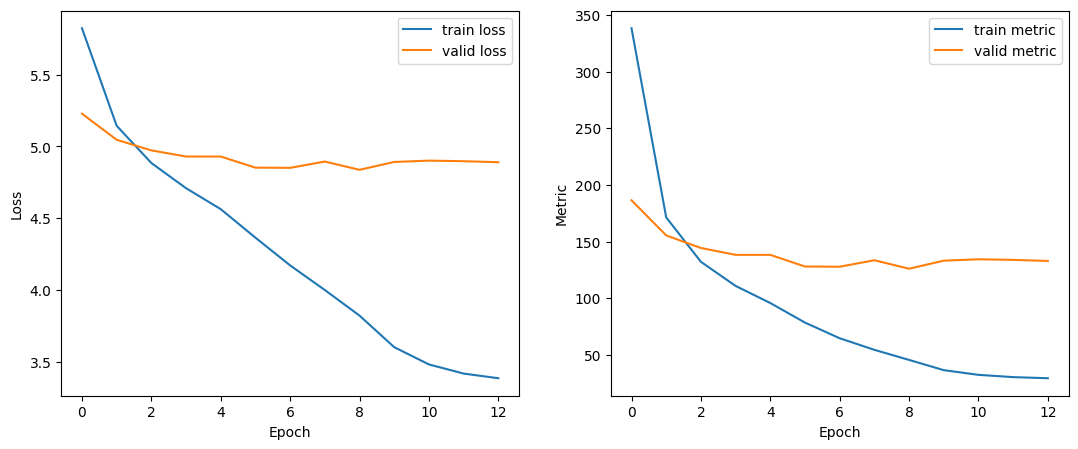

In [ ]:
plt.figure(figsize = (13, 5))
plt.subplot(1, 2, 1)
plt.plot(range(0, stop), train_loss_hist, label = 'train loss')
plt.plot(range(0, stop), valid_loss_hist, label = 'valid loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(range(0, stop), train_metric_hist, label = 'train metric')
plt.plot(range(0, stop), valid_metric_hist, label = 'valid metric')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.show()

In [ ]:
min(valid_metric_hist)

126.077880859375

## 🔵 **Test**

In [ ]:
model = torch.load('/content/best_model.pt')

In [ ]:
model.eval()
with torch.no_grad():
  _, _ = evaluate(model, test_loader, loss_func, metric)

Loss : 4.7758636474609375, Metric : 118.61248779296875


# 🔴 **Train ➰**

🔰 This is the template for train function, change it if needed.

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=None):
  model.train()
  loss_train = AverageMeter()
  metric.reset()

  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.t().to(device)
      targets = targets.t().to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs.reshape(-1, outputs.size(-1)), targets.reshape(-1))

      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      metric.update(outputs, targets)

      tepoch.set_postfix(loss=loss_train.avg, metric=metric.compute().item())

  return model, loss_train.avg, metric.compute().item()

# 🔴 **Evaluation**

🔰 This is the template for evaluation function, change it if needed.

In [ ]:
def evaluate(model, data_loader, loss_fn, metric):
  model.eval()
  metric.reset()

  loss_valid = AverageMeter()

  for inputs, targets in data_loader:

    inputs = inputs.t().to(device)
    targets   = targets.t().to(device)

    with torch.no_grad():
      outputs = model(inputs)

    loss = loss_fn(outputs.reshape(-1, outputs.size(-1)), targets.reshape(-1))
    loss_valid.update(loss)
    metric.update(outputs, targets)

  print(f'Loss : {loss_valid.avg.item()}, Metric : {metric.compute().item()}')

  return loss_valid.avg.item(), metric.compute().item()

# 🔵 **NT-ASGD**

In [ ]:
class LanguageModel(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate, bidirectional):
    super(LanguageModel, self).__init__()

    self.embedding = nn.Embedding(vocab_size, embedding_dim)

    self.lstm      = nn.LSTM(input_size = embedding_dim,
                             hidden_size = hidden_dim,
                             num_layers = num_layers,
                             batch_first = False,
                             bidirectional = bidirectional,
                             dropout = dropout_rate)

    D = [2 if bidirectional == True else 1]

    self.cls      = nn.Linear(hidden_dim * D[0], vocab_size)

  def forward(self, src):

    embedded_src  = self.embedding(src)
    out, _        = self.lstm(embedded_src)
    out           = self.cls(out)

    return out

In [ ]:
model = LanguageModel(vocab_size, 400, 650, 3, 0.2, False).to(device)
model, num_trainable_params(model)

(LanguageModel(
   (embedding): Embedding(28783, 400)
   (lstm): LSTM(400, 650, num_layers=3, dropout=0.2)
   (cls): Linear(in_features=650, out_features=28783, bias=True)
 ),
 39.756533)

In [ ]:
train_loss_hist, valid_loss_hist = [], []
train_metric_hist, valid_metric_hist = [], []
best_metric = torch.inf

In [ ]:
lr = 10
optimizer = NTASGD(model.parameters(), lr = lr, weight_decay = 1.2e-6)
loss_func = nn.CrossEntropyLoss()
metric    = tm.text.Perplexity().to(device)

In [ ]:
set_seed(42)
start, stop = 14, 15
wait        = 0

for  epoch in range(start, stop):
  model, train_loss, metric_train = train_one_epoch(model, train_loader, loss_func, optimizer, metric, epoch)
  valid_loss, metric_valid        = evaluate(model, valid_loader, loss_func, metric)

  train_loss_hist.append(train_loss)
  train_metric_hist.append(metric_train)
  valid_loss_hist.append(valid_loss)
  valid_metric_hist.append(metric_valid)

  if metric_valid<best_metric:
    wait = 0

    best_metric = metric_valid

    torch.save(model, 'best_model.pt')
    print('model saved!')

  else:
    wait += 1
    if wait == 1:
      wait = 0
      lr = 0.3 * lr
      optimizer = NTASGD(model.parameters(), lr = lr, weight_decay = 1.2e-6)
      print(f'Change learning rate = {lr}')

Epoch 14: 100%|██████████| 1491/1491 [02:57<00:00,  8.41batch/s, loss=3.58, metric=35.7]


Loss : 4.821430206298828, Metric : 124.17341613769531
Change learning rate = 0.007289999999999998


## 🔵 **plot**

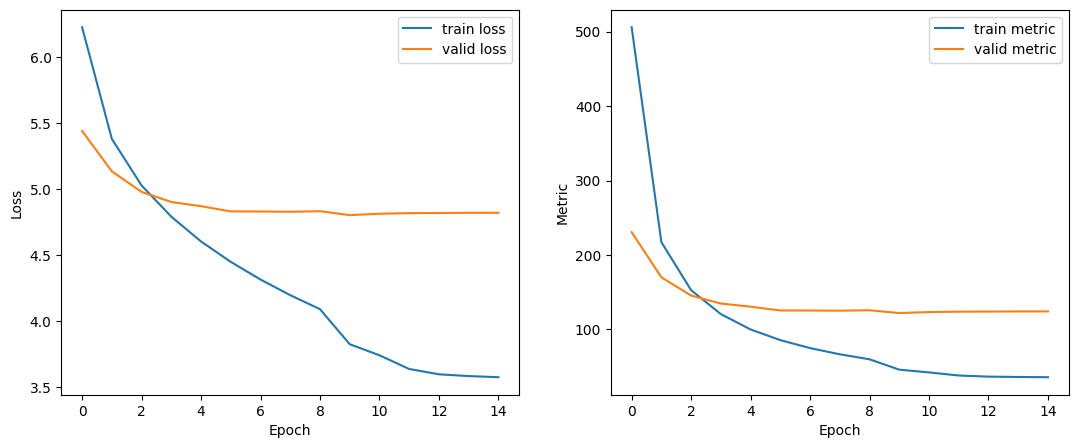

In [ ]:
plt.figure(figsize = (13, 5))
plt.subplot(1, 2, 1)
plt.plot(range(0, stop), train_loss_hist, label = 'train loss')
plt.plot(range(0, stop), valid_loss_hist, label = 'valid loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(range(0, stop), train_metric_hist, label = 'train metric')
plt.plot(range(0, stop), valid_metric_hist, label = 'valid metric')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.show()

In [ ]:
min(valid_metric_hist)

121.96973419189453

## 🔵 **Test**

In [ ]:
model = torch.load('/content/best_model.pt').to(device)

In [ ]:
model.eval()
with torch.no_grad():
  _, _ = evaluate(model, test_loader, loss_func, metric)

Loss : 4.758429050445557, Metric : 116.55644989013672


# 🔵 **Combination Weight-dropped and NTASGD**

In [ ]:
model = LanguageModelWD(vocab_size, 400, 650, 3, 0.0, False, 0.5).to(device)
model, num_trainable_params(model)

Applying weight drop of 0.5 to weight_hh_l0
Applying weight drop of 0.5 to weight_hh_l0
Applying weight drop of 0.5 to weight_hh_l0


(LanguageModelWD(
   (embedding): Embedding(28783, 400)
   (lstms): ModuleList(
     (0): WeightDrop(
       (module): LSTM(400, 650, batch_first=True)
     )
     (1-2): 2 x WeightDrop(
       (module): LSTM(650, 650, batch_first=True)
     )
   )
   (cls): Linear(in_features=650, out_features=28783, bias=True)
 ),
 39.756533)

In [ ]:
train_loss_hist, valid_loss_hist = [], []
train_metric_hist, valid_metric_hist = [], []
best_metric = torch.inf

In [ ]:
lr = 12
optimizer = NTASGD(model.parameters(), lr = lr, weight_decay = 1.2e-6)
loss_func = nn.CrossEntropyLoss()
metric    = tm.text.Perplexity().to(device)

In [ ]:
set_seed(42)

start, stop = 14, 20
wait = 0

for  epoch in range(start, stop):
  model, train_loss, metric_train = train_one_epoch(model, train_loader, loss_func, optimizer, metric, epoch)
  valid_loss, metric_valid        = evaluate(model, valid_loader, loss_func, metric)

  train_loss_hist.append(train_loss)
  train_metric_hist.append(metric_train)
  valid_loss_hist.append(valid_loss)
  valid_metric_hist.append(metric_valid)

  if metric_valid<best_metric:
    wait = 0

    best_metric = metric_valid

    torch.save(model, 'best_model.pt')
    print('model saved!')

  else:
    wait += 1
    if wait >= 2:
      wait = 0
      lr = 0.1 * lr
      optimizer = NTASGD(model.parameters(), lr = lr, weight_decay = 1.2e-6)
      print(f'Change learning rate = {lr}')

Epoch 14: 100%|██████████| 1491/1491 [02:33<00:00,  9.74batch/s, loss=4.91, metric=136]


Loss : 5.4969801902771, Metric : 243.96005249023438


Epoch 15: 100%|██████████| 1491/1491 [02:31<00:00,  9.86batch/s, loss=4.9, metric=134]


Loss : 5.500492572784424, Metric : 244.82241821289062
Change learning rate = 0.12000000000000002


Epoch 16: 100%|██████████| 1491/1491 [02:30<00:00,  9.88batch/s, loss=4.87, metric=131]


Loss : 5.499475002288818, Metric : 244.57237243652344


Epoch 17: 100%|██████████| 1491/1491 [02:30<00:00,  9.88batch/s, loss=4.87, metric=130]


Loss : 5.500916957855225, Metric : 244.92575073242188
Change learning rate = 0.012000000000000004


Epoch 18: 100%|██████████| 1491/1491 [02:30<00:00,  9.88batch/s, loss=4.87, metric=130]


Loss : 5.500858783721924, Metric : 244.91116333007812


Epoch 19: 100%|██████████| 1491/1491 [02:30<00:00,  9.88batch/s, loss=4.87, metric=130]


Loss : 5.500869274139404, Metric : 244.91419982910156
Change learning rate = 0.0012000000000000005


## 🔵 **plot**

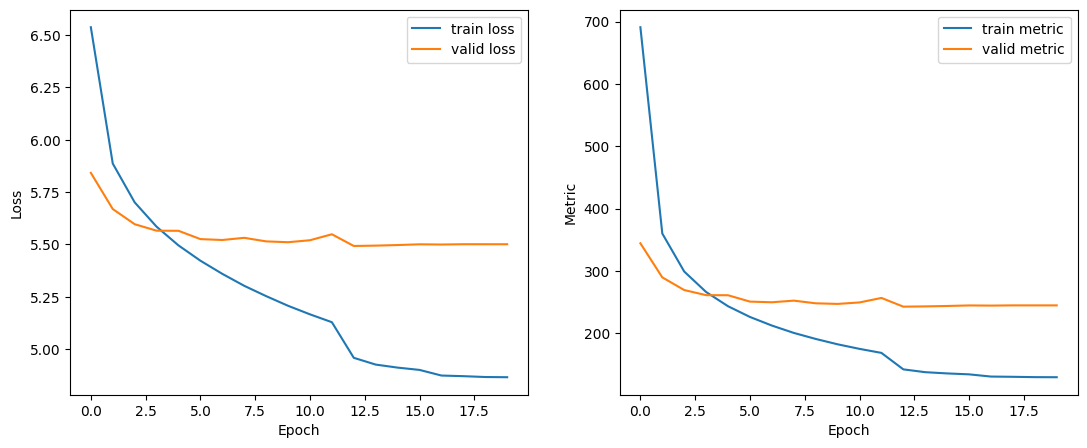

In [ ]:
plt.figure(figsize = (13, 5))
plt.subplot(1, 2, 1)
plt.plot(range(0, stop), train_loss_hist, label = 'train loss')
plt.plot(range(0, stop), valid_loss_hist, label = 'valid loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(range(0, stop), train_metric_hist, label = 'train metric')
plt.plot(range(0, stop), valid_metric_hist, label = 'valid metric')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.show()

In [ ]:
min(valid_metric_hist)

242.873291015625

## 🔵 **Test**

In [ ]:
model = torch.load('/content/best_model.pt').to(device)

In [ ]:
model.eval()
with torch.no_grad():
  _, _ = evaluate(model, test_loader, loss_func, metric)

Loss : 5.428662300109863, Metric : 227.84622192382812


# 🔵 **Variational dropout**

In [ ]:
from torch.autograd import Variable
class VariationalDropout(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input, dropout):
        if self.training:
            mask = torch.empty(input.size(1), input.size(2), device = input.device).bernoulli_(1-dropout)/(1-dropout)
            mask = mask.expand_as(input)
            return mask * input
        else:
            return input

    def __repr__(self):
        return "VariationalDropout()"

class LockedDropout(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, dropout=0.5):
        if not self.training or not dropout:
            return x
        m = x.data.new(1, x.size(1), x.size(2)).bernoulli_(1 - dropout)
        mask = Variable(m, requires_grad=False) / (1 - dropout)
        mask = mask.expand_as(x)
        return mask * x

In [ ]:
class LanguageModelVD(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers,
               dropout_rate, bidirectional, wdrop = None, dropout_i = 0.4,
               dropout_l = 0.3, dropout_o = 0.4):

    super(LanguageModelVD, self).__init__()

    self.embedding = nn.Embedding(vocab_size, embedding_dim)

    self.lstms     = [nn.LSTM(input_size = embedding_dim if n == 0 else hidden_dim,
                              hidden_size = hidden_dim,
                              num_layers = 1,
                              batch_first = True,
                              bidirectional = bidirectional,
                              dropout = dropout_rate) for n in range(num_layers)]
    if wdrop:
      self.lstms = [WeightDrop(lstm, ['weight_hh_l0'], dropout=wdrop) for lstm in self.lstms]

    self.lstms     = nn.ModuleList(self.lstms)

    self.dropout   = VariationalDropout()
    self.dropout_i = dropout_i
    self.dropout_l = dropout_l
    self.dropout_o = dropout_o


    D = [2 if bidirectional == True else 1]

    self.cls      = nn.Linear(hidden_dim * D[0], vocab_size)

  def forward(self, src):

    embedded_src  = self.embedding(src)

    embedded_src  = self.dropout(embedded_src, self.dropout_i)

    for i, lstm in enumerate(self.lstms):
        out, _        = lstm(embedded_src)
        embedded_src  = self.dropout(out, self.dropout_l if i != len(self.lstms)-1 else self.dropout_o)

    out           = self.cls(out)

    return out

In [ ]:
model = LanguageModelVD(vocab_size, 400, 650, 3, 0.0, False, None, 0.65, 0.3, 0.4).to(device)
model, num_trainable_params(model)

(LanguageModelVD(
   (embedding): Embedding(28783, 400)
   (lstms): ModuleList(
     (0): LSTM(400, 650, batch_first=True)
     (1-2): 2 x LSTM(650, 650, batch_first=True)
   )
   (dropout): VariationalDropout()
   (cls): Linear(in_features=650, out_features=28783, bias=True)
 ),
 39.756533)

In [ ]:
train_loss_hist, valid_loss_hist = [], []
train_metric_hist, valid_metric_hist = [], []
best_metric = torch.inf

In [ ]:
lr = 4
optimizer = optim.SGD(model.parameters(), lr = lr, weight_decay = 1.2e-6)
loss_func = nn.CrossEntropyLoss()
metric    = tm.text.Perplexity().to(device)

In [ ]:
start, stop = 23, 40
wait = 0
for  epoch in range(start, stop):
  model, train_loss, metric_train = train_one_epoch(model, train_loader, loss_func, optimizer, metric, epoch)
  valid_loss, metric_valid        = evaluate(model, valid_loader, loss_func, metric)

  train_loss_hist.append(train_loss)
  train_metric_hist.append(metric_train)
  valid_loss_hist.append(valid_loss)
  valid_metric_hist.append(metric_valid)

  if metric_valid<best_metric:
    wait = 0

    best_metric = metric_valid

    torch.save(model, 'best_model.pt')
    print('model saved!')

  else:
    wait += 1
    if wait >= 2:
      wait = 0
      lr = 0.2 * lr
      optimizer = optim.SGD(model.parameters(), lr = lr, weight_decay = 1.2e-6)
      print(f'Change learning rate = {lr}')

Epoch 23: 100%|██████████| 1491/1491 [02:34<00:00,  9.67batch/s, loss=5.24, metric=189]


Loss : 5.490261554718018, Metric : 242.32913208007812
model saved!


Epoch 24: 100%|██████████| 1491/1491 [02:32<00:00,  9.78batch/s, loss=5.22, metric=185]


Loss : 5.4873881340026855, Metric : 241.63336181640625
model saved!


Epoch 25: 100%|██████████| 1491/1491 [02:32<00:00,  9.75batch/s, loss=5.21, metric=183]


Loss : 5.484929084777832, Metric : 241.03977966308594
model saved!


Epoch 26: 100%|██████████| 1491/1491 [02:32<00:00,  9.79batch/s, loss=5.2, metric=182]


Loss : 5.485623359680176, Metric : 241.20718383789062


Epoch 27: 100%|██████████| 1491/1491 [02:32<00:00,  9.80batch/s, loss=5.2, metric=181]


Loss : 5.484395503997803, Metric : 240.91131591796875
model saved!


Epoch 28: 100%|██████████| 1491/1491 [02:32<00:00,  9.80batch/s, loss=5.19, metric=180]


Loss : 5.483216762542725, Metric : 240.6261444091797
model saved!


Epoch 29: 100%|██████████| 1491/1491 [02:32<00:00,  9.80batch/s, loss=5.19, metric=180]


Loss : 5.4856181144714355, Metric : 241.20523071289062


Epoch 30: 100%|██████████| 1491/1491 [02:32<00:00,  9.79batch/s, loss=5.19, metric=179]


Loss : 5.482617378234863, Metric : 240.48126220703125
model saved!


Epoch 31: 100%|██████████| 1491/1491 [02:32<00:00,  9.79batch/s, loss=5.19, metric=179]


Loss : 5.483902931213379, Metric : 240.79039001464844


Epoch 32: 100%|██████████| 1491/1491 [02:32<00:00,  9.80batch/s, loss=5.18, metric=178]


Loss : 5.481624603271484, Metric : 240.2428741455078
model saved!


Epoch 33: 100%|██████████| 1491/1491 [02:32<00:00,  9.79batch/s, loss=5.18, metric=178]


Loss : 5.482782363891602, Metric : 240.52243041992188


Epoch 34: 100%|██████████| 1491/1491 [02:32<00:00,  9.78batch/s, loss=5.18, metric=177]


Loss : 5.479751110076904, Metric : 239.79273986816406
model saved!


Epoch 35: 100%|██████████| 1491/1491 [02:32<00:00,  9.78batch/s, loss=5.18, metric=177]


Loss : 5.481048107147217, Metric : 240.10406494140625


Epoch 36: 100%|██████████| 1491/1491 [02:32<00:00,  9.80batch/s, loss=5.17, metric=177]


Loss : 5.4815592765808105, Metric : 240.2283172607422
Change learning rate = 0.16000000000000003


Epoch 37: 100%|██████████| 1491/1491 [02:32<00:00,  9.76batch/s, loss=5.17, metric=176]


Loss : 5.481163501739502, Metric : 240.13304138183594


Epoch 38: 100%|██████████| 1491/1491 [02:32<00:00,  9.78batch/s, loss=5.17, metric=176]


Loss : 5.479934215545654, Metric : 239.8375701904297
Change learning rate = 0.03200000000000001


Epoch 39: 100%|██████████| 1491/1491 [02:32<00:00,  9.77batch/s, loss=5.17, metric=176]


Loss : 5.4806389808654785, Metric : 240.0064239501953


## 🔵 **Plot**

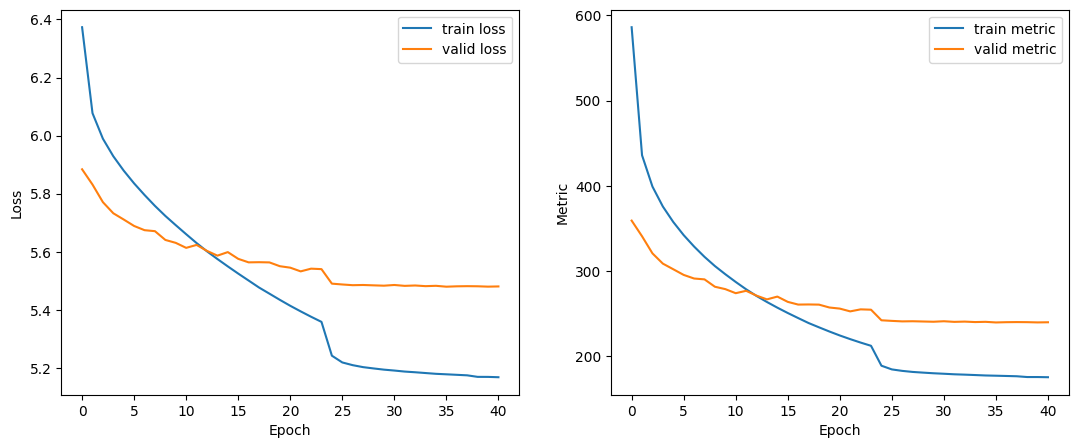

In [ ]:
plt.figure(figsize = (13, 5))
plt.subplot(1, 2, 1)
plt.plot(range(0, stop), train_loss_hist, label = 'train loss')
plt.plot(range(0, stop), valid_loss_hist, label = 'valid loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(range(0, stop), train_metric_hist, label = 'train metric')
plt.plot(range(0, stop), valid_metric_hist, label = 'valid metric')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.show()

In [ ]:
min(valid_metric_hist)

239.79273986816406

## 🔵 **Test**

In [ ]:
model = torch.load('/content/best_model.pt').to(device)

In [ ]:
model.eval()
with torch.no_grad():
  _, _ = evaluate(model, test_loader, loss_func, metric)

Loss : 5.415444850921631, Metric : 224.85501098632812


# 🔵 **Combination WD, NTASGD and VD**

In [ ]:
model = LanguageModelVD(vocab_size, 400, 650, 3, 0.0, False, 0.5, 0.65, 0.3, 0.4).to(device)
model, num_trainable_params(model)

Applying weight drop of 0.5 to weight_hh_l0
Applying weight drop of 0.5 to weight_hh_l0
Applying weight drop of 0.5 to weight_hh_l0


(LanguageModelVD(
   (embedding): Embedding(28783, 400)
   (lstms): ModuleList(
     (0): WeightDrop(
       (module): LSTM(400, 650, batch_first=True)
     )
     (1-2): 2 x WeightDrop(
       (module): LSTM(650, 650, batch_first=True)
     )
   )
   (dropout): VariationalDropout()
   (cls): Linear(in_features=650, out_features=28783, bias=True)
 ),
 39.756533)

In [ ]:
train_loss_hist, valid_loss_hist = [], []
train_metric_hist, valid_metric_hist = [], []
best_metric = torch.inf

In [ ]:
lr = 5
optimizer = NTASGD(model.parameters(), lr = 5, weight_decay = 1.2e-6)
loss_func = nn.CrossEntropyLoss()
metric    = tm.text.Perplexity().to(device)

In [ ]:
start, stop = 0, 12

for  epoch in range(start, stop):
  model, train_loss, metric_train = train_one_epoch(model, train_loader, loss_func, optimizer, metric, epoch)
  valid_loss, metric_valid        = evaluate(model, valid_loader, loss_func, metric)

  train_loss_hist.append(train_loss)
  train_metric_hist.append(metric_train)
  valid_loss_hist.append(valid_loss)
  valid_metric_hist.append(metric_valid)

  if metric_valid<best_metric:

    best_metric = metric_valid

    torch.save(model, 'best_model.pt')
    print('model saved!')

  else:
    wait += 1
    if wait >= 2:
      wait = 0
      lr = 0.2 * lr
      optimizer = NTASGD(model.parameters(), lr = lr, weight_decay = 1.2e-6)
      print(f'Change learning rate = {lr}')

Epoch 0:   0%|          | 0/1491 [00:00<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:812: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
<ipython-input-98-637ebbafbf7f>:36: UserWarning: This overload of add is deprecated:
	add(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1485.)
  grad = grad.add(group['weight_decay'], p.data)
Epoch 0: 100%|██████████| 1491/1491 [02:32<00:00,  9.78batch/s, loss=6.86, metric=949]


Loss : 6.216207027435303, Metric : 500.77716064453125
model saved!


Epoch 1: 100%|██████████| 1491/1491 [02:32<00:00,  9.80batch/s, loss=6.34, metric=570]


Loss : 6.012552738189697, Metric : 408.5472412109375
model saved!


Epoch 2: 100%|██████████| 1491/1491 [02:31<00:00,  9.83batch/s, loss=6.18, metric=481]


Loss : 5.853817462921143, Metric : 348.55047607421875
model saved!


Epoch 3: 100%|██████████| 1491/1491 [02:32<00:00,  9.80batch/s, loss=6.08, metric=438]


Loss : 5.813275337219238, Metric : 334.7123718261719
model saved!


Epoch 4: 100%|██████████| 1491/1491 [02:31<00:00,  9.82batch/s, loss=6.03, metric=414]


Loss : 5.800795555114746, Metric : 330.5563049316406
model saved!


Epoch 5: 100%|██████████| 1491/1491 [02:34<00:00,  9.63batch/s, loss=5.98, metric=397]


Loss : 5.747087478637695, Metric : 313.2818298339844
model saved!


Epoch 6:  88%|████████▊ | 1314/1491 [02:14<00:18,  9.75batch/s, loss=5.95, metric=384]

## 🔵 **Plot**

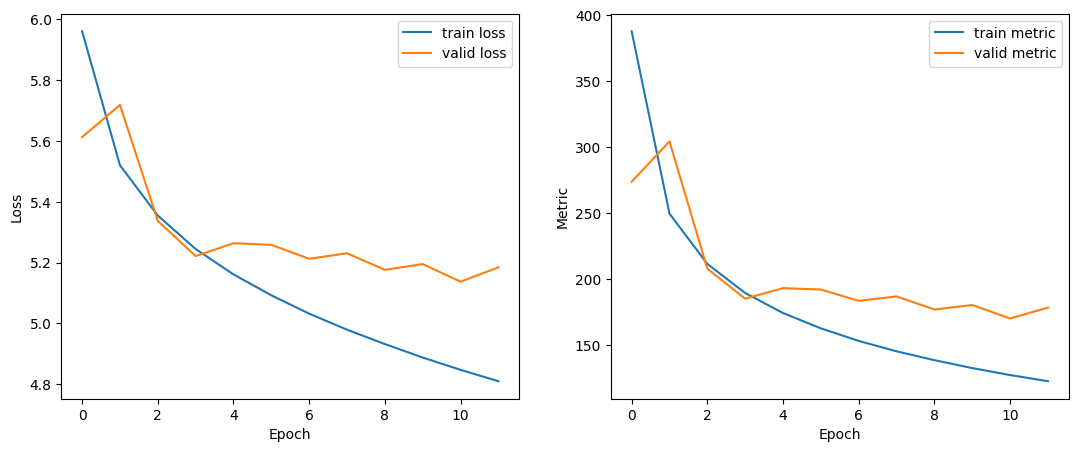

In [ ]:
plt.figure(figsize = (13, 5))
plt.subplot(1, 2, 1)
plt.plot(range(0, stop), train_loss_hist, label = 'train loss')
plt.plot(range(0, stop), valid_loss_hist, label = 'valid loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(range(0, stop), train_metric_hist, label = 'train metric')
plt.plot(range(0, stop), valid_metric_hist, label = 'valid metric')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.show()

In [ ]:
min(valid_metric_hist)

170.2892303466797

## 🔵 **Test**

In [ ]:
model = torch.load('/content/best_model.pt').to(device)

In [ ]:
model.eval()
with torch.no_grad():
  _, _ = evaluate(model, test_loader, loss_func, metric)

Loss : 5.071981906890869, Metric : 159.48988342285156


# 🔵 **Embedding-dropout**

In [ ]:
def embedded_dropout(embed, words, dropout=0.1, scale=None):
  if dropout:
    mask = embed.weight.data.new().resize_((embed.weight.size(0), 1)).bernoulli_(1 - dropout).expand_as(embed.weight) / (1 - dropout)
    masked_embed_weight = mask * embed.weight
  else:
    masked_embed_weight = embed.weight
  if scale:
    masked_embed_weight = scale.expand_as(masked_embed_weight) * masked_embed_weight

  padding_idx = embed.padding_idx
  if padding_idx is None:
      padding_idx = -1

  X = torch.nn.functional.embedding(words, masked_embed_weight,
    padding_idx, embed.max_norm, embed.norm_type,
    embed.scale_grad_by_freq, embed.sparse
  )
  return X

In [ ]:
class LanguageModelED(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers,
               dropout_rate, bidirectional, wdrop = None, dropout_i = 0.4,
               dropout_l = 0.3, dropout_o = 0.4, dropout_em = 0):

    super(LanguageModelED, self).__init__()

    self.embedding = nn.Embedding(vocab_size, embedding_dim)

    self.lstms     = [nn.LSTM(input_size = embedding_dim if n == 0 else hidden_dim,
                              hidden_size = hidden_dim,
                              num_layers = 1,
                              batch_first = True,
                              bidirectional = bidirectional,
                              dropout = dropout_rate) for n in range(num_layers)]
    if wdrop:
      self.lstms = [WeightDrop(lstm, ['weight_hh_l0'], dropout=wdrop) for lstm in self.lstms]

    self.lstms      = nn.ModuleList(self.lstms)

    self.dropout    = VariationalDropout()
    self.dropout_i  = dropout_i
    self.dropout_l  = dropout_l
    self.dropout_o  = dropout_o
    self.dropout_em = dropout_em


    D = [2 if bidirectional == True else 1]

    self.cls      = nn.Linear(hidden_dim * D[0], vocab_size)

  def forward(self, src):

    embedded_src  = embedded_dropout(self.embedding, src, self.dropout_em if self.training else 0)

    embedded_src  = self.dropout(embedded_src, self.dropout_i)

    for i, lstm in enumerate(self.lstms):
        out, _        = lstm(embedded_src)
        embedded_src  = self.dropout(out, self.dropout_l if i != len(self.lstms)-1 else self.dropout_o)

    out           = self.cls(out)

    return out

In [ ]:
model = LanguageModelED(vocab_size, 512, 256, 2, 0.0, False,None, 0, 0, 0, dropout_em = 0.1).to(device)
model, num_trainable_params(model)

(LanguageModelED(
   (embedding): Embedding(23749, 512)
   (lstms): ModuleList(
     (0): LSTM(512, 256, batch_first=True)
     (1): LSTM(256, 256, batch_first=True)
   )
   (dropout): VariationalDropout()
   (cls): Linear(in_features=256, out_features=23749, bias=True)
 ),
 19.577797)

In [ ]:
train_loss_hist, valid_loss_hist = [], []
train_metric_hist, valid_metric_hist = [], []
best_metric = torch.inf

In [ ]:
optimizer = optim.SGD(model.parameters(), lr = 1.5, weight_decay = 1e-6)
loss_func = nn.CrossEntropyLoss()
metric    = tm.text.Perplexity().to(device)

In [ ]:
start, stop = 0, 15

for  epoch in range(start, stop):
  model, train_loss, metric_train = train_one_epoch(model, train_loader, loss_func, optimizer, metric, epoch)
  valid_loss, metric_valid        = evaluate(model, valid_loader, loss_func, metric)

  train_loss_hist.append(train_loss)
  train_metric_hist.append(metric_train)
  valid_loss_hist.append(valid_loss)
  valid_metric_hist.append(metric_valid)

  if metric_valid<best_metric:

    best_metric = metric_valid

    torch.save(model, 'best_model.pt')
    print('model saved!')

Epoch 0: 100%|██████████| 5858/5858 [01:53<00:00, 51.54batch/s, loss=6.09, metric=443]


Loss : 5.597630977630615, Metric : 269.8509826660156
model saved!


Epoch 1: 100%|██████████| 5858/5858 [01:53<00:00, 51.81batch/s, loss=5.57, metric=264]


Loss : 5.500044345855713, Metric : 244.7307891845703
model saved!


Epoch 2: 100%|██████████| 5858/5858 [01:52<00:00, 52.03batch/s, loss=5.36, metric=214]


Loss : 5.275752067565918, Metric : 195.56471252441406
model saved!


Epoch 3: 100%|██████████| 5858/5858 [01:51<00:00, 52.64batch/s, loss=5.22, metric=185]


Loss : 5.164964199066162, Metric : 175.06549072265625
model saved!


Epoch 4: 100%|██████████| 5858/5858 [01:51<00:00, 52.38batch/s, loss=5.11, metric=166]


Loss : 5.095171928405762, Metric : 163.2599334716797
model saved!


Epoch 5: 100%|██████████| 5858/5858 [01:51<00:00, 52.74batch/s, loss=5.02, metric=151]


Loss : 5.085810661315918, Metric : 161.74075317382812
model saved!


Epoch 6: 100%|██████████| 5858/5858 [01:51<00:00, 52.41batch/s, loss=4.95, metric=141]


Loss : 5.104666233062744, Metric : 164.8171844482422


Epoch 7: 100%|██████████| 5858/5858 [01:52<00:00, 52.11batch/s, loss=4.88, metric=132]


Loss : 5.025773525238037, Metric : 152.32498168945312
model saved!


Epoch 8: 100%|██████████| 5858/5858 [01:52<00:00, 52.22batch/s, loss=4.82, metric=124]


Loss : 5.0453081130981445, Metric : 155.31480407714844


Epoch 9: 100%|██████████| 5858/5858 [01:52<00:00, 52.22batch/s, loss=4.77, metric=118]


Loss : 5.024903774261475, Metric : 152.1865997314453
model saved!


Epoch 10: 100%|██████████| 5858/5858 [01:52<00:00, 52.26batch/s, loss=4.72, metric=113]


Loss : 5.027065753936768, Metric : 152.5250701904297


Epoch 11: 100%|██████████| 5858/5858 [01:51<00:00, 52.46batch/s, loss=4.68, metric=107]


Loss : 5.011534690856934, Metric : 150.15594482421875
model saved!


Epoch 12: 100%|██████████| 5858/5858 [01:51<00:00, 52.40batch/s, loss=4.64, metric=103]


Loss : 5.025565147399902, Metric : 152.28277587890625


Epoch 13: 100%|██████████| 5858/5858 [01:52<00:00, 52.03batch/s, loss=4.6, metric=99.4]


Loss : 5.014795303344727, Metric : 150.6577606201172


Epoch 14: 100%|██████████| 5858/5858 [01:52<00:00, 52.11batch/s, loss=4.56, metric=96]


Loss : 5.021556854248047, Metric : 151.68185424804688


## 🔵 **Plot**

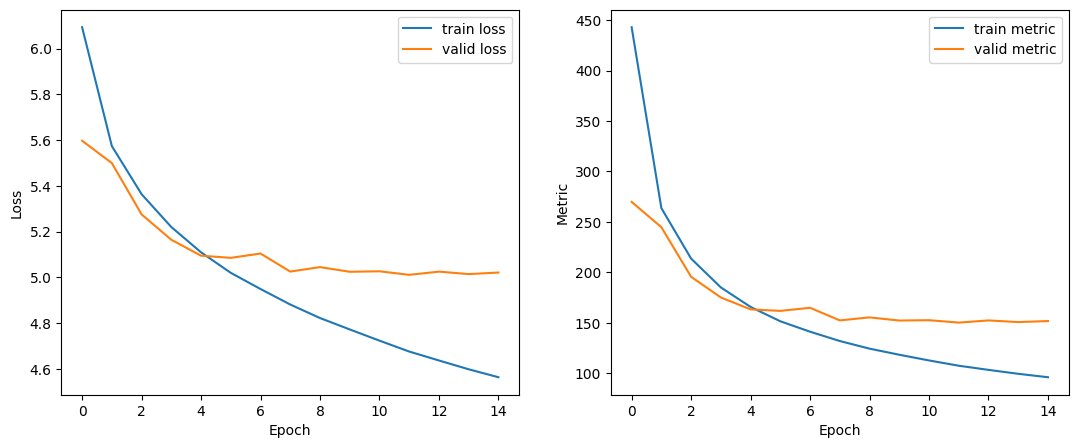

In [ ]:
plt.figure(figsize = (13, 5))
plt.subplot(1, 2, 1)
plt.plot(range(0, stop), train_loss_hist, label = 'train loss')
plt.plot(range(0, stop), valid_loss_hist, label = 'valid loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(range(0, stop), train_metric_hist, label = 'train metric')
plt.plot(range(0, stop), valid_metric_hist, label = 'valid metric')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.show()

In [ ]:
min(valid_metric_hist)

150.15594482421875

## 🔵 **Test**

In [ ]:
model = torch.load('/content/best_model.pt').to(device)

In [ ]:
model.eval()
with torch.no_grad():
  _, _ = evaluate(model, test_loader, loss_func, metric)

Loss : 4.948273658752441, Metric : 140.93185424804688


# 🔵 **Combination WD, NTASGD, VD, ED**

In [ ]:
model = LanguageModelED(vocab_size, 512, 256, 2, 0.0, False, 0.1, 0.00, 0.1, 0.4, dropout_em = 0.1).to(device)
model, num_trainable_params(model)

Applying weight drop of 0.1 to weight_hh_l0
Applying weight drop of 0.1 to weight_hh_l0


(LanguageModelED(
   (embedding): Embedding(23749, 512)
   (lstms): ModuleList(
     (0): WeightDrop(
       (module): LSTM(512, 256, batch_first=True)
     )
     (1): WeightDrop(
       (module): LSTM(256, 256, batch_first=True)
     )
   )
   (dropout): VariationalDropout()
   (cls): Linear(in_features=256, out_features=23749, bias=True)
 ),
 19.577797)

In [ ]:
train_loss_hist, valid_loss_hist = [], []
train_metric_hist, valid_metric_hist = [], []
best_metric = torch.inf

In [ ]:
optimizer = NTASGD(model.parameters(), lr = 5, weight_decay = 0)
loss_func = nn.CrossEntropyLoss()
metric    = tm.text.Perplexity().to(device)

In [ ]:
start, stop = 0, 12

for  epoch in range(start, stop):
  model, train_loss, metric_train = train_one_epoch(model, train_loader, loss_func, optimizer, metric, epoch)
  valid_loss, metric_valid        = evaluate(model, valid_loader, loss_func, metric)

  train_loss_hist.append(train_loss)
  train_metric_hist.append(metric_train)
  valid_loss_hist.append(valid_loss)
  valid_metric_hist.append(metric_valid)

  if metric_valid<best_metric:

    best_metric = metric_valid

    torch.save(model, 'best_model.pt')
    print('model saved!')

Epoch 0:   0%|          | 0/5858 [00:00<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:812: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
<ipython-input-53-637ebbafbf7f>:38: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1485.)
  p.data.add_(-group['lr'], grad)
Epoch 0: 100%|██████████| 5858/5858 [01:53<00:00, 51.46batch/s, loss=5.99, metric=398]


Loss : 5.496739387512207, Metric : 243.9191131591797
model saved!


Epoch 1: 100%|██████████| 5858/5858 [01:52<00:00, 52.24batch/s, loss=5.5, metric=244]


Loss : 5.311678886413574, Metric : 202.71710205078125
model saved!


Epoch 2: 100%|██████████| 5858/5858 [01:52<00:00, 52.10batch/s, loss=5.31, metric=203]


Loss : 5.2184953689575195, Metric : 184.6903076171875
model saved!


Epoch 3: 100%|██████████| 5858/5858 [01:53<00:00, 51.76batch/s, loss=5.19, metric=180]


Loss : 5.154836654663086, Metric : 173.3042755126953
model saved!


Epoch 4: 100%|██████████| 5858/5858 [01:51<00:00, 52.41batch/s, loss=5.1, metric=164]


Loss : 5.154675483703613, Metric : 173.27890014648438
model saved!


Epoch 5: 100%|██████████| 5858/5858 [01:51<00:00, 52.31batch/s, loss=5.02, metric=152]


Loss : 5.184024333953857, Metric : 178.4410858154297


Epoch 6: 100%|██████████| 5858/5858 [01:52<00:00, 52.29batch/s, loss=4.96, metric=143]


Loss : 5.143155097961426, Metric : 171.28970336914062
model saved!


Epoch 7: 100%|██████████| 5858/5858 [01:51<00:00, 52.39batch/s, loss=4.91, metric=135]


Loss : 5.169257640838623, Metric : 175.82737731933594


Epoch 8: 100%|██████████| 5858/5858 [01:52<00:00, 52.01batch/s, loss=4.86, metric=129]


Loss : 5.1446051597595215, Metric : 171.53965759277344


Epoch 9: 100%|██████████| 5858/5858 [01:51<00:00, 52.38batch/s, loss=4.81, metric=123]


Loss : 5.363206386566162, Metric : 213.41818237304688


Epoch 10: 100%|██████████| 5858/5858 [01:52<00:00, 52.15batch/s, loss=4.77, metric=118]


Loss : 5.1853251457214355, Metric : 178.68434143066406


Epoch 11: 100%|██████████| 5858/5858 [01:53<00:00, 51.71batch/s, loss=4.73, metric=114]


Loss : 5.211291313171387, Metric : 183.3690185546875


## 🔵 **Plot**

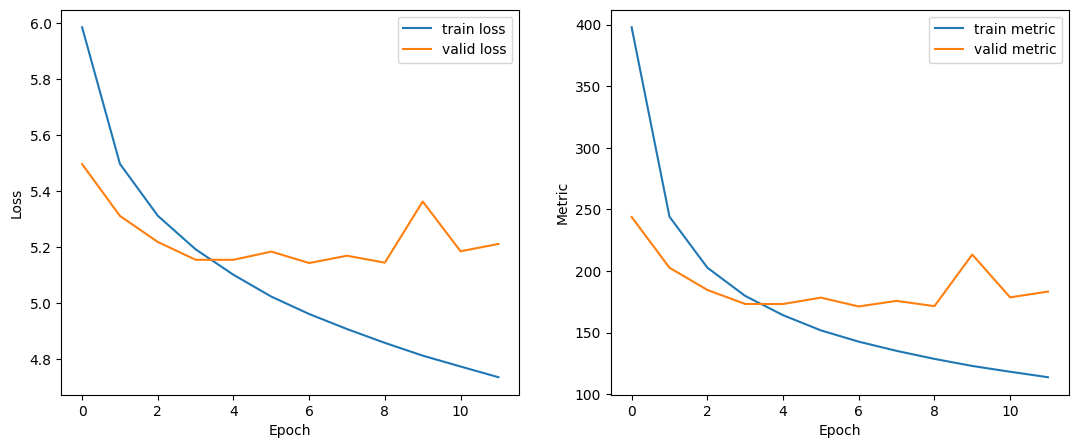

In [ ]:
plt.figure(figsize = (13, 5))
plt.subplot(1, 2, 1)
plt.plot(range(0, stop), train_loss_hist, label = 'train loss')
plt.plot(range(0, stop), valid_loss_hist, label = 'valid loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(range(0, stop), train_metric_hist, label = 'train metric')
plt.plot(range(0, stop), valid_metric_hist, label = 'valid metric')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.show()

In [ ]:
min(valid_metric_hist)

171.28970336914062

## 🔵 **Test**

In [ ]:
model = torch.load('/content/best_model.pt').to(device)

In [ ]:
model.eval()
with torch.no_grad():
  _, _ = evaluate(model, test_loader, loss_func, metric)

Loss : 5.074094772338867, Metric : 159.826904296875


# 🔵 **Weight tying**

In [62]:
class LanguageModelED(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers,
               dropout_rate, bidirectional, wdrop = None, dropout_i = 0.4,
               dropout_l = 0.3, dropout_o = 0.4, dropout_em = 0, tie_weight = False):

    super(LanguageModelED, self).__init__()

    self.embedding = nn.Embedding(vocab_size, embedding_dim)

    self.lstms     = [nn.LSTM(input_size = embedding_dim if n == 0 else hidden_dim,
                              hidden_size = hidden_dim if n != num_layers - 1 else (embedding_dim if tie_weight else hidden_dim),
                              num_layers = 1,
                              batch_first = True,
                              bidirectional = bidirectional,
                              dropout = dropout_rate) for n in range(num_layers)]
    if wdrop:
      self.lstms = [WeightDrop(lstm, ['weight_hh_l0'], dropout=wdrop) for lstm in self.lstms]

    self.lstms      = nn.ModuleList(self.lstms)

    self.dropout    = VariationalDropout()
    self.dropout_i  = dropout_i
    self.dropout_l  = dropout_l
    self.dropout_o  = dropout_o
    self.dropout_em = dropout_em


    D = [2 if bidirectional == True else 1]

    self.cls      = nn.Linear(embedding_dim * D[0] if tie_weight else hidden_dim * D[0], vocab_size)

    if tie_weight:
      self.cls.weight = self.embedding.weight

  def forward(self, src):

    embedded_src  = embedded_dropout(self.embedding, src, self.dropout_em if self.training else 0)

    embedded_src  = self.dropout(embedded_src, self.dropout_i)

    for i, lstm in enumerate(self.lstms):
        embedded_src, _        = lstm(embedded_src)
        embedded_src  = self.dropout(embedded_src, self.dropout_l if i != len(self.lstms)-1 else self.dropout_o)

    out           = self.cls(embedded_src)

    return out

In [63]:
model = LanguageModelED(vocab_size, 400, 650, 3, 0.0, False, None, 0, 0, 0, 0, tie_weight = True).to(device)
model, num_trainable_params(model)

(LanguageModelED(
   (embedding): Embedding(28783, 400)
   (lstms): ModuleList(
     (0): LSTM(400, 650, batch_first=True)
     (1): LSTM(650, 650, batch_first=True)
     (2): LSTM(650, 400, batch_first=True)
   )
   (dropout): VariationalDropout()
   (cls): Linear(in_features=400, out_features=28783, bias=True)
 ),
 19.345583)

In [64]:
train_loss_hist, valid_loss_hist = [], []
train_metric_hist, valid_metric_hist = [], []
best_metric = torch.inf

In [65]:
lr = 8
optimizer = optim.SGD(model.parameters(), lr = lr, weight_decay = 1e-6)
loss_func = nn.CrossEntropyLoss()
metric    = tm.text.Perplexity().to(device)

In [67]:
start, stop = 21, 22
wait = 0
for  epoch in range(start, stop):
  model, train_loss, metric_train = train_one_epoch(model, train_loader, loss_func, optimizer, metric, epoch)
  valid_loss, metric_valid        = evaluate(model, valid_loader, loss_func, metric)

  train_loss_hist.append(train_loss)
  train_metric_hist.append(metric_train)
  valid_loss_hist.append(valid_loss)
  valid_metric_hist.append(metric_valid)

  if metric_valid<best_metric:
    wait = 0

    best_metric = metric_valid

    torch.save(model, 'best_model.pt')
    print('model saved!')
  else:
    wait += 1
    if wait == 1:
      wait = 0
      lr = 0.6 * lr
      optimizer = optim.SGD(model.parameters(), lr = lr, momentum = 0.9, weight_decay = 1.2e-6)
      print(f'Change learning rate = {lr}')

Epoch 21: 100%|██████████| 1491/1491 [02:05<00:00, 11.87batch/s, loss=2.45, metric=11.6]


Loss : 5.429601669311523, Metric : 228.0842742919922
Change learning rate = 0.37324799999999997


## 🔵 **Plot**

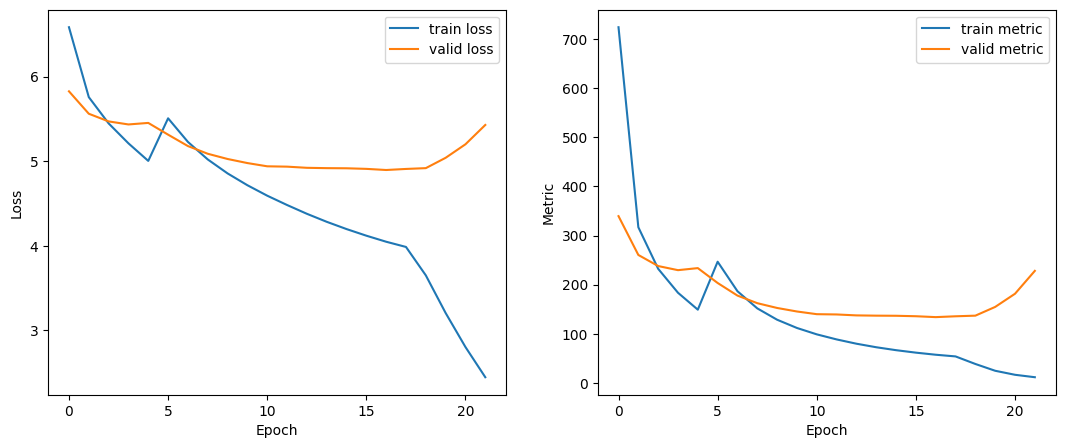

In [68]:
plt.figure(figsize = (13, 5))
plt.subplot(1, 2, 1)
plt.plot(range(0, stop), train_loss_hist, label = 'train loss')
plt.plot(range(0, stop), valid_loss_hist, label = 'valid loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(range(0, stop), train_metric_hist, label = 'train metric')
plt.plot(range(0, stop), valid_metric_hist, label = 'valid metric')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.show()

In [69]:
min(valid_metric_hist)

133.91009521484375

## 🔵 **Test**

In [70]:
model = torch.load('/content/best_model.pt').to(device)

In [71]:
model.eval()
with torch.no_grad():
  _, _ = evaluate(model, test_loader, loss_func, metric)

Loss : 4.839788913726807, Metric : 126.44139099121094


# 🔵 **Combination WD, NTASGD, VD, ED and WT**

In [ ]:
model = LanguageModelED(vocab_size, 512, 256, 2, 0.0, False,0.1, 0.00, 0.1, 0.4, 0.1, tie_weight = True).to(device)
model, num_trainable_params(model)

Applying weight drop of 0.1 to weight_hh_l0
Applying weight drop of 0.1 to weight_hh_l0


(LanguageModelED(
   (embedding): Embedding(23749, 512)
   (lstms): ModuleList(
     (0-1): 2 x WeightDrop(
       (module): LSTM(512, 512, batch_first=True)
     )
   )
   (dropout): VariationalDropout()
   (cls): Linear(in_features=512, out_features=23749, bias=True)
 ),
 16.385733)

In [ ]:
train_loss_hist, valid_loss_hist = [], []
train_metric_hist, valid_metric_hist = [], []
best_metric = torch.inf

In [ ]:
optimizer = NTASGD(model.parameters(), lr = 0.3, weight_decay = 1e-6)
loss_func = nn.CrossEntropyLoss()
metric    = tm.text.Perplexity().to(device)

In [ ]:
start, stop = 8, 12

for  epoch in range(start, stop):
  model, train_loss, metric_train = train_one_epoch(model, train_loader, loss_func, optimizer, metric, epoch)
  valid_loss, metric_valid        = evaluate(model, valid_loader, loss_func, metric)

  train_loss_hist.append(train_loss)
  train_metric_hist.append(metric_train)
  valid_loss_hist.append(valid_loss)
  valid_metric_hist.append(metric_valid)

  if metric_valid<best_metric:

    best_metric = metric_valid

    torch.save(model, 'best_model.pt')
    print('model saved!')

Epoch 8: 100%|██████████| 5858/5858 [02:46<00:00, 35.12batch/s, loss=5.56, metric=259]


Loss : 5.65190315246582, Metric : 284.8801574707031
model saved!


Epoch 9: 100%|██████████| 5858/5858 [02:38<00:00, 36.99batch/s, loss=5.51, metric=247]


Loss : 5.637276649475098, Metric : 280.7539978027344
model saved!


Epoch 10: 100%|██████████| 5858/5858 [02:38<00:00, 36.98batch/s, loss=5.47, metric=237]


Loss : 5.624670505523682, Metric : 277.2391052246094
model saved!


Epoch 11: 100%|██████████| 5858/5858 [02:37<00:00, 37.10batch/s, loss=5.43, metric=228]


Loss : 5.616347789764404, Metric : 274.93829345703125
model saved!


## 🔵 **Plot**

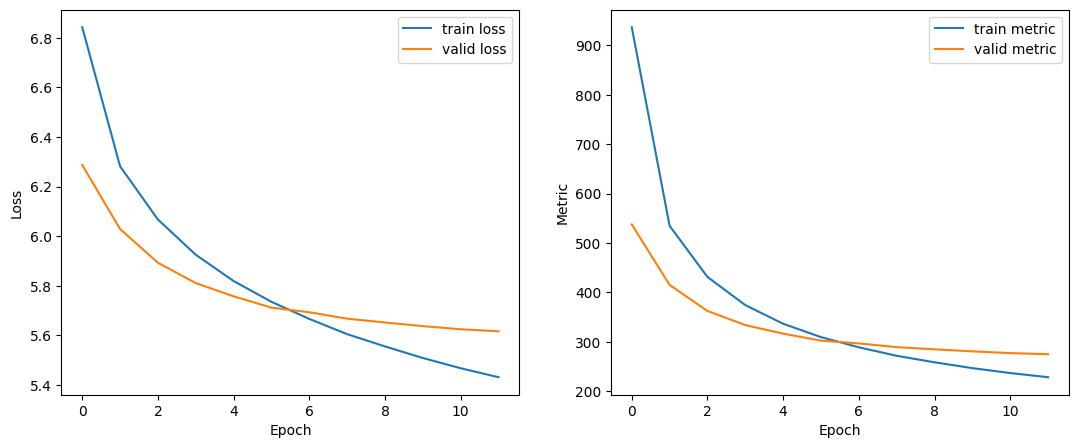

In [ ]:
plt.figure(figsize = (13, 5))
plt.subplot(1, 2, 1)
plt.plot(range(0, stop), train_loss_hist, label = 'train loss')
plt.plot(range(0, stop), valid_loss_hist, label = 'valid loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(range(0, stop), train_metric_hist, label = 'train metric')
plt.plot(range(0, stop), valid_metric_hist, label = 'valid metric')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.show()

In [ ]:
min(valid_metric_hist)

274.93829345703125

## 🔵 **Test**

In [ ]:
model = torch.load('/content/best_model.pt').to(device)

In [ ]:
model.eval()
with torch.no_grad():
  _, _ = evaluate(model, test_loader, loss_func, metric)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:812: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


Loss : 5.522099018096924, Metric : 250.1611328125


# 🔵 **Some details**

In [ ]:
set_seed(42)
class LanguageModelED(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers,
               dropout_rate, bidirectional, wdrop = None, dropout_i = 0.65,
               dropout_l = 0.3, dropout_o = 0.4, dropout_em = 0.1, tie_weight = False):

    super(LanguageModelED, self).__init__()

    self.vocab_size    = vocab_size
    self.embedding_dim = embedding_dim
    self.hidden_dim    = hidden_dim
    self.num_layers    = num_layers
    self.tie_weight    = tie_weight

    self.embedding = nn.Embedding(vocab_size, embedding_dim)

    self.lstms     = [nn.LSTM(input_size = embedding_dim if n == 0 else hidden_dim,
                              hidden_size = hidden_dim if n != num_layers - 1 else (embedding_dim if tie_weight else hidden_dim),
                              num_layers = 1,
                              batch_first = False,
                              bidirectional = bidirectional,
                              dropout = dropout_rate) for n in range(num_layers)]
    if wdrop:
      self.lstms = [WeightDrop(lstm, ['weight_hh_l0'], dropout=wdrop) for lstm in self.lstms]

    self.lstms      = nn.ModuleList(self.lstms)

    self.dropout    = LockedDropout()
    self.dropout_i  = dropout_i
    self.dropout_l  = dropout_l
    self.dropout_o  = dropout_o
    self.dropout_em = dropout_em


    D = [2 if bidirectional == True else 1]

    self.cls      = nn.Linear(embedding_dim * D[0] if tie_weight else hidden_dim * D[0], vocab_size)

    if tie_weight:
      self.cls.weight = self.embedding.weight

    self.init_weights()

  def forward(self, src):#, hidden):

    embedded_src  = embedded_dropout(self.embedding, src, self.dropout_em if self.training else 0)

    embedded_src  = self.dropout(embedded_src, self.dropout_i)

    hiddens = []

    for i, lstm in enumerate(self.lstms):

        out, new_hidden = lstm(embedded_src)#, hidden[i])
        if i != self.num_layers - 1:
            embedded_src    = self.dropout(out, self.dropout_l)
        #hiddens.append(new_hidden)

    out = self.dropout(out, self.dropout_o)

    hidden = hiddens

    out           = self.cls(out)

    return out, hidden

  def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.cls.bias.data.fill_(0)
        self.cls.weight.data.uniform_(-initrange, initrange)

  def init_hidden(self, bsz):
        weight = next(self.parameters()).data
        return [(weight.new(1, bsz, self.hidden_dim if l != self.num_layers - 1 else (self.embedding_dim if self.tie_weight else self.hidden_dim)).zero_(),
                weight.new(1, bsz, self.hidden_dim if l != self.num_layers - 1 else (self.embedding_dim if self.tie_weight else self.hidden_dim)).zero_())
                for l in range(self.num_layers)]

In [ ]:
def repackage_hidden(h):
    """Wraps hidden states in new Tensors,
    to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, batch_size, epoch=None):
  model.train()
  loss_train = AverageMeter()
  metric.reset()

  counter = 0
  #hidden = model.init_hidden(batch_size)
  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.t().to(device)
      targets = targets.t().to(device)

      #if counter == 0:
      #  hidden = model.init_hidden(batch_size)
      #if inputs.shape[1]<batch_size:
      #  hidden = model.init_hidden(inputs.shape[1])
      #counter += 1

      #hidden = repackage_hidden(hidden)

      outputs, hidden = model(inputs)#, hidden)

      loss = loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())

      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      metric.update(outputs, targets)

      tepoch.set_postfix(loss=loss_train.avg, metric=metric.compute().item())

  return model, loss_train.avg, metric.compute().item()

In [ ]:
def evaluate(model, data_loader, loss_fn, metric, batch_size):
  model.eval()
  metric.reset()

  loss_valid = AverageMeter()

  counter = 0
  #hidden = model.init_hidden(batch_size)
  for inputs, targets in data_loader:

    inputs = inputs.t().to(device)
    targets   = targets.t().to(device)

    #if counter == 0:
    #    hidden = model.init_hidden(batch_size)
    #if inputs.shape[1]<batch_size:
    #    hidden = model.init_hidden(inputs.shape[1])
    #counter += 1

    with torch.no_grad():
      outputs, hidden = model(inputs)#, hidden)

    #hidden = repackage_hidden(hidden)

    loss = loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())
    loss_valid.update(loss)
    metric.update(outputs, targets)

  print(f'Loss : {loss_valid.avg.item()}, Metric : {metric.compute().item()}')

  return loss_valid.avg.item(), metric.compute().item()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
#350 1050

In [ ]:
model = LanguageModelED(vocab_size, 400, 1150, 3, 0.0, False, None, 0.65, 0.3, 0.4, 0.1, tie_weight = True).to(device)
model, num_trainable_params(model)

(LanguageModelED(
   (embedding): Embedding(28783, 400)
   (lstms): ModuleList(
     (0): LSTM(400, 1150)
     (1): LSTM(1150, 1150)
     (2): LSTM(1150, 400)
   )
   (dropout): LockedDropout()
   (cls): Linear(in_features=400, out_features=28783, bias=True)
 ),
 31.753583)

In [ ]:
train_loss_hist, valid_loss_hist = [], []
train_metric_hist, valid_metric_hist = [], []
best_metric = torch.inf

In [ ]:
lr = 30
optimizer = NTASGD(model.parameters(), lr = lr ,weight_decay = 1.2e-6)
loss_func = nn.CrossEntropyLoss()
metric    = tm.text.Perplexity().to(device)

In [ ]:
set_seed(42)
start, stop = 0, 90
wait = 0
for  epoch in range(start, stop):
  model, train_loss, metric_train = train_one_epoch(model, train_loader, loss_func, optimizer, metric, 20, epoch)
  valid_loss, metric_valid        = evaluate(model, valid_loader, loss_func, metric, 20)

  train_loss_hist.append(train_loss)
  train_metric_hist.append(metric_train)
  valid_loss_hist.append(valid_loss)
  valid_metric_hist.append(metric_valid)

  torch.save(train_loss_hist, 'train_loss_hist.pt')
  torch.save(train_metric_hist, 'train_metric_hist.pt')
  torch.save(valid_loss_hist, 'valid_loss_hist.pt')
  torch.save(valid_metric_hist, 'valid_metric_hist.pt')

  if metric_valid<best_metric:
    wait = 0

    best_metric = metric_valid

    torch.save(model, 'best_model.pt')
    print('model saved!')
  else:
    wait += 1
    print(f'wait>>>>{wait}')
    if wait >= 2 and epoch>=75:
      wait = 0
      #model = torch.load('/content/best_model.pt').to(device)
      lr = 0.3 * lr
      optimizer = NTASGD(model.parameters(), lr = lr ,weight_decay = 1.2e-6)
      print(f'Change learning rate = {lr}')

Epoch 0: 100%|██████████| 1491/1491 [03:13<00:00,  7.69batch/s, loss=6.5, metric=664]


Loss : 5.626622200012207, Metric : 277.78656005859375
model saved!


Epoch 1: 100%|██████████| 1491/1491 [03:13<00:00,  7.71batch/s, loss=5.78, metric=325]


Loss : 5.277275562286377, Metric : 195.89659118652344
model saved!


Epoch 2: 100%|██████████| 1491/1491 [03:13<00:00,  7.72batch/s, loss=5.53, metric=253]


Loss : 5.102972030639648, Metric : 164.5545196533203
model saved!


Epoch 3: 100%|██████████| 1491/1491 [03:13<00:00,  7.69batch/s, loss=5.37, metric=215]


Loss : 4.999271392822266, Metric : 148.34707641601562
model saved!


Epoch 4: 100%|██████████| 1491/1491 [03:13<00:00,  7.69batch/s, loss=5.25, metric=190]


Loss : 4.915471076965332, Metric : 136.41275024414062
model saved!


Epoch 5: 100%|██████████| 1491/1491 [03:13<00:00,  7.71batch/s, loss=5.16, metric=175]


Loss : 4.8323798179626465, Metric : 125.53047943115234
model saved!


Epoch 6: 100%|██████████| 1491/1491 [03:14<00:00,  7.67batch/s, loss=5.09, metric=163]


Loss : 4.792527675628662, Metric : 120.62769317626953
model saved!


Epoch 7: 100%|██████████| 1491/1491 [03:14<00:00,  7.66batch/s, loss=5.03, metric=153]


Loss : 4.767165184020996, Metric : 117.60792541503906
model saved!


Epoch 8: 100%|██████████| 1491/1491 [03:15<00:00,  7.62batch/s, loss=4.99, metric=146]


Loss : 4.75820779800415, Metric : 116.55744934082031
model saved!


Epoch 9: 100%|██████████| 1491/1491 [03:15<00:00,  7.64batch/s, loss=4.94, metric=140]


Loss : 4.710089683532715, Metric : 111.08209228515625
model saved!


Epoch 10: 100%|██████████| 1491/1491 [03:17<00:00,  7.57batch/s, loss=4.9, metric=134]


Loss : 4.693362712860107, Metric : 109.23770141601562
model saved!


Epoch 11: 100%|██████████| 1491/1491 [03:16<00:00,  7.60batch/s, loss=4.87, metric=130]


Loss : 4.683531284332275, Metric : 108.17086029052734
model saved!


Epoch 12: 100%|██████████| 1491/1491 [03:15<00:00,  7.63batch/s, loss=4.84, metric=127]


Loss : 4.667008876800537, Metric : 106.39612579345703
model saved!


Epoch 13: 100%|██████████| 1491/1491 [03:14<00:00,  7.66batch/s, loss=4.82, metric=124]


Loss : 4.658021450042725, Metric : 105.4444808959961
model saved!


Epoch 14: 100%|██████████| 1491/1491 [03:15<00:00,  7.64batch/s, loss=4.79, metric=120]


Loss : 4.625487327575684, Metric : 102.07161712646484
model saved!


Epoch 15: 100%|██████████| 1491/1491 [03:15<00:00,  7.64batch/s, loss=4.77, metric=118]


Loss : 4.649886608123779, Metric : 104.59272003173828
wait>>>>1


Epoch 16: 100%|██████████| 1491/1491 [03:15<00:00,  7.64batch/s, loss=4.75, metric=116]


Loss : 4.639084339141846, Metric : 103.46324157714844
wait>>>>2


Epoch 17: 100%|██████████| 1491/1491 [03:14<00:00,  7.68batch/s, loss=4.73, metric=114]


Loss : 4.617740631103516, Metric : 101.27767181396484
model saved!


Epoch 18: 100%|██████████| 1491/1491 [03:14<00:00,  7.68batch/s, loss=4.71, metric=111]


Loss : 4.613539695739746, Metric : 100.85575103759766
model saved!


Epoch 19: 100%|██████████| 1491/1491 [03:14<00:00,  7.66batch/s, loss=4.7, metric=110]


Loss : 4.591658115386963, Metric : 98.67326354980469
model saved!


Epoch 20: 100%|██████████| 1491/1491 [03:14<00:00,  7.67batch/s, loss=4.68, metric=108]


Loss : 4.598215579986572, Metric : 99.32935333251953
wait>>>>1


Epoch 21: 100%|██████████| 1491/1491 [03:14<00:00,  7.67batch/s, loss=4.67, metric=107]


Loss : 4.593005180358887, Metric : 98.80839538574219
wait>>>>2


Epoch 22: 100%|██████████| 1491/1491 [03:14<00:00,  7.68batch/s, loss=4.65, metric=105]


Loss : 4.595466136932373, Metric : 99.05152893066406
wait>>>>3


Epoch 23: 100%|██████████| 1491/1491 [03:14<00:00,  7.68batch/s, loss=4.64, metric=104]


Loss : 4.602939605712891, Metric : 99.80146026611328
wait>>>>4


Epoch 24: 100%|██████████| 1491/1491 [03:14<00:00,  7.68batch/s, loss=4.63, metric=103]


Loss : 4.59269380569458, Metric : 98.78045654296875
wait>>>>5


Epoch 25: 100%|██████████| 1491/1491 [03:13<00:00,  7.70batch/s, loss=4.62, metric=101]


Loss : 4.569361209869385, Metric : 96.49832916259766
model saved!


Epoch 26: 100%|██████████| 1491/1491 [03:13<00:00,  7.69batch/s, loss=4.61, metric=100]


Loss : 4.572870254516602, Metric : 96.84068298339844
wait>>>>1


Epoch 27: 100%|██████████| 1491/1491 [03:14<00:00,  7.67batch/s, loss=4.6, metric=99.1]


Loss : 4.568855285644531, Metric : 96.45411682128906
model saved!


Epoch 28: 100%|██████████| 1491/1491 [03:14<00:00,  7.67batch/s, loss=4.59, metric=98.5]


Loss : 4.543567657470703, Metric : 94.04246520996094
model saved!


Epoch 29: 100%|██████████| 1491/1491 [03:14<00:00,  7.68batch/s, loss=4.58, metric=97.5]


Loss : 4.542665958404541, Metric : 93.9571304321289
model saved!


Epoch 30: 100%|██████████| 1491/1491 [03:13<00:00,  7.69batch/s, loss=4.57, metric=96.5]


Loss : 4.545694828033447, Metric : 94.2393569946289
wait>>>>1


Epoch 31: 100%|██████████| 1491/1491 [03:14<00:00,  7.67batch/s, loss=4.56, metric=95.8]


Loss : 4.541492938995361, Metric : 93.84339904785156
model saved!


Epoch 32: 100%|██████████| 1491/1491 [03:14<00:00,  7.68batch/s, loss=4.55, metric=94.9]


Loss : 4.542898178100586, Metric : 93.97831726074219
wait>>>>1


Epoch 33: 100%|██████████| 1491/1491 [03:14<00:00,  7.68batch/s, loss=4.54, metric=93.9]


Loss : 4.555559158325195, Metric : 95.18077850341797
wait>>>>2


Epoch 34: 100%|██████████| 1491/1491 [03:14<00:00,  7.68batch/s, loss=4.54, metric=93.7]


Loss : 4.5514936447143555, Metric : 94.79090118408203
wait>>>>3


Epoch 35: 100%|██████████| 1491/1491 [03:14<00:00,  7.68batch/s, loss=4.53, metric=93]


Loss : 4.55478572845459, Metric : 95.10791778564453
wait>>>>4


Epoch 36: 100%|██████████| 1491/1491 [03:13<00:00,  7.69batch/s, loss=4.53, metric=92.5]


Loss : 4.542332649230957, Metric : 93.92948913574219
wait>>>>5


Epoch 37: 100%|██████████| 1491/1491 [03:13<00:00,  7.69batch/s, loss=4.52, metric=91.7]


Loss : 4.534054756164551, Metric : 93.15168762207031
model saved!


Epoch 38: 100%|██████████| 1491/1491 [03:13<00:00,  7.69batch/s, loss=4.51, metric=91]


Loss : 4.540790557861328, Metric : 93.78104400634766
wait>>>>1


Epoch 39: 100%|██████████| 1491/1491 [03:14<00:00,  7.67batch/s, loss=4.51, metric=90.9]


Loss : 4.517604827880859, Metric : 91.63070678710938
model saved!


Epoch 40: 100%|██████████| 1491/1491 [03:14<00:00,  7.68batch/s, loss=4.5, metric=90.3]


Loss : 4.516552925109863, Metric : 91.53572845458984
model saved!


Epoch 41: 100%|██████████| 1491/1491 [03:14<00:00,  7.66batch/s, loss=4.5, metric=90]


Loss : 4.528584957122803, Metric : 92.64259338378906
wait>>>>1


Epoch 42: 100%|██████████| 1491/1491 [03:14<00:00,  7.67batch/s, loss=4.49, metric=89.4]


Loss : 4.524381637573242, Metric : 92.25408935546875
wait>>>>2


Epoch 43: 100%|██████████| 1491/1491 [03:14<00:00,  7.68batch/s, loss=4.49, metric=88.9]


Loss : 4.525814533233643, Metric : 92.38554382324219
wait>>>>3


Epoch 44: 100%|██████████| 1491/1491 [03:14<00:00,  7.67batch/s, loss=4.48, metric=88.3]


Loss : 4.539121150970459, Metric : 93.6223373413086
wait>>>>4


Epoch 45: 100%|██████████| 1491/1491 [03:14<00:00,  7.68batch/s, loss=4.48, metric=87.8]


Loss : 4.569013595581055, Metric : 96.4659423828125
wait>>>>5


Epoch 46: 100%|██████████| 1491/1491 [03:14<00:00,  7.66batch/s, loss=4.47, metric=87.6]


Loss : 4.530189514160156, Metric : 92.79264068603516
wait>>>>6


Epoch 47: 100%|██████████| 1491/1491 [03:15<00:00,  7.65batch/s, loss=4.47, metric=87.3]


Loss : 4.512966632843018, Metric : 91.20603942871094
model saved!


Epoch 48: 100%|██████████| 1491/1491 [03:14<00:00,  7.68batch/s, loss=4.47, metric=87]


Loss : 4.511213302612305, Metric : 91.04917907714844
model saved!


Epoch 49: 100%|██████████| 1491/1491 [03:14<00:00,  7.67batch/s, loss=4.46, metric=86.7]


Loss : 4.5399956703186035, Metric : 93.70955657958984
wait>>>>1


Epoch 50: 100%|██████████| 1491/1491 [03:15<00:00,  7.64batch/s, loss=4.46, metric=86.2]


Loss : 4.5104570388793945, Metric : 90.97943115234375
model saved!


Epoch 51: 100%|██████████| 1491/1491 [03:14<00:00,  7.66batch/s, loss=4.45, metric=85.6]


Loss : 4.510000228881836, Metric : 90.93987274169922
model saved!


Epoch 52: 100%|██████████| 1491/1491 [03:15<00:00,  7.64batch/s, loss=4.45, metric=85.8]


Loss : 4.509917259216309, Metric : 90.93025207519531
model saved!


Epoch 53: 100%|██████████| 1491/1491 [03:14<00:00,  7.67batch/s, loss=4.45, metric=85.3]


Loss : 4.517870903015137, Metric : 91.65404510498047
wait>>>>1


Epoch 54: 100%|██████████| 1491/1491 [03:14<00:00,  7.66batch/s, loss=4.45, metric=85.2]


Loss : 4.514832973480225, Metric : 91.37816619873047
wait>>>>2


Epoch 55: 100%|██████████| 1491/1491 [03:14<00:00,  7.66batch/s, loss=4.44, metric=84.8]


Loss : 4.499630928039551, Metric : 90.0018081665039
model saved!


Epoch 56: 100%|██████████| 1491/1491 [03:13<00:00,  7.69batch/s, loss=4.44, metric=84.7]


Loss : 4.527909755706787, Metric : 92.57869720458984
wait>>>>1


Epoch 57: 100%|██████████| 1491/1491 [03:14<00:00,  7.66batch/s, loss=4.44, metric=84.4]


Loss : 4.52092981338501, Metric : 91.93961334228516
wait>>>>2


Epoch 58: 100%|██████████| 1491/1491 [03:14<00:00,  7.66batch/s, loss=4.43, metric=83.9]


Loss : 4.519039630889893, Metric : 91.76219177246094
wait>>>>3


Epoch 59: 100%|██████████| 1491/1491 [03:14<00:00,  7.68batch/s, loss=4.43, metric=83.7]


Loss : 4.513744354248047, Metric : 91.27595520019531
wait>>>>4


Epoch 60: 100%|██████████| 1491/1491 [03:13<00:00,  7.70batch/s, loss=4.42, metric=83.5]


Loss : 4.506109237670898, Metric : 90.58472442626953
wait>>>>5


Epoch 61: 100%|██████████| 1491/1491 [03:14<00:00,  7.67batch/s, loss=4.42, metric=83.3]


Loss : 4.503513336181641, Metric : 90.34854888916016
wait>>>>6


Epoch 62: 100%|██████████| 1491/1491 [03:14<00:00,  7.66batch/s, loss=4.42, metric=83.1]


Loss : 4.494935989379883, Metric : 89.57559204101562
model saved!


Epoch 63: 100%|██████████| 1491/1491 [03:14<00:00,  7.65batch/s, loss=4.41, metric=82.6]


Loss : 4.513612270355225, Metric : 91.26860809326172
wait>>>>1


Epoch 64: 100%|██████████| 1491/1491 [03:14<00:00,  7.66batch/s, loss=4.41, metric=82.5]


Loss : 4.489258289337158, Metric : 89.07715606689453
model saved!


Epoch 65: 100%|██████████| 1491/1491 [03:14<00:00,  7.67batch/s, loss=4.41, metric=82.2]


Loss : 4.4963698387146, Metric : 89.70856475830078
wait>>>>1


Epoch 66: 100%|██████████| 1491/1491 [03:14<00:00,  7.68batch/s, loss=4.41, metric=82.1]


Loss : 4.509056091308594, Metric : 90.85258483886719
wait>>>>2


Epoch 67: 100%|██████████| 1491/1491 [03:14<00:00,  7.66batch/s, loss=4.41, metric=82]


Loss : 4.507165431976318, Metric : 90.6778564453125
wait>>>>3


Epoch 68: 100%|██████████| 1491/1491 [03:14<00:00,  7.67batch/s, loss=4.41, metric=82]


Loss : 4.504311561584473, Metric : 90.42070007324219
wait>>>>4


Epoch 69: 100%|██████████| 1491/1491 [03:14<00:00,  7.65batch/s, loss=4.4, metric=81.7]


Loss : 4.498824119567871, Metric : 89.92918395996094
wait>>>>5


Epoch 70: 100%|██████████| 1491/1491 [03:14<00:00,  7.67batch/s, loss=4.4, metric=81.3]


Loss : 4.497522830963135, Metric : 89.81077575683594
wait>>>>6


Epoch 71: 100%|██████████| 1491/1491 [03:14<00:00,  7.67batch/s, loss=4.4, metric=81.4]


Loss : 4.497848987579346, Metric : 89.83905029296875
wait>>>>7


Epoch 72: 100%|██████████| 1491/1491 [03:14<00:00,  7.67batch/s, loss=4.39, metric=80.7]


Loss : 4.491570949554443, Metric : 89.27105712890625
wait>>>>8


Epoch 73: 100%|██████████| 1491/1491 [03:14<00:00,  7.66batch/s, loss=4.39, metric=80.7]


Loss : 4.492092609405518, Metric : 89.32389068603516
wait>>>>9


Epoch 74: 100%|██████████| 1491/1491 [03:14<00:00,  7.67batch/s, loss=4.39, metric=80.7]


Loss : 4.500574588775635, Metric : 90.08399200439453
wait>>>>10


Epoch 75: 100%|██████████| 1491/1491 [03:15<00:00,  7.64batch/s, loss=4.38, metric=80.1]


Loss : 4.5019097328186035, Metric : 90.2023696899414
wait>>>>11
Change learning rate = 9.0


Epoch 76: 100%|██████████| 1491/1491 [03:14<00:00,  7.66batch/s, loss=4.21, metric=67.3]


Loss : 4.4236531257629395, Metric : 83.41519165039062
model saved!


Epoch 77: 100%|██████████| 1491/1491 [03:15<00:00,  7.64batch/s, loss=4.15, metric=63.5]


Loss : 4.41173791885376, Metric : 82.42561340332031
model saved!


Epoch 78: 100%|██████████| 1491/1491 [03:14<00:00,  7.65batch/s, loss=4.12, metric=61.7]


Loss : 4.404472827911377, Metric : 81.82598876953125
model saved!


Epoch 79: 100%|██████████| 1491/1491 [03:14<00:00,  7.66batch/s, loss=4.1, metric=60.4]


Loss : 4.408054351806641, Metric : 82.12091064453125
wait>>>>1


Epoch 80: 100%|██████████| 1491/1491 [03:14<00:00,  7.66batch/s, loss=4.09, metric=59.5]


Loss : 4.409261226654053, Metric : 82.22035217285156
wait>>>>2
Change learning rate = 2.6999999999999997


Epoch 81: 100%|██████████| 1491/1491 [03:14<00:00,  7.66batch/s, loss=4.03, metric=56]


Loss : 4.392711639404297, Metric : 80.87091827392578
model saved!


Epoch 82: 100%|██████████| 1491/1491 [03:14<00:00,  7.66batch/s, loss=4.01, metric=54.9]


Loss : 4.39246940612793, Metric : 80.85086059570312
model saved!


Epoch 83: 100%|██████████| 1491/1491 [03:14<00:00,  7.66batch/s, loss=4, metric=54.3]


Loss : 4.390810489654541, Metric : 80.71734619140625
model saved!


Epoch 84: 100%|██████████| 1491/1491 [03:14<00:00,  7.66batch/s, loss=3.99, metric=54.1]


Loss : 4.389575958251953, Metric : 80.61849975585938
model saved!


Epoch 85: 100%|██████████| 1491/1491 [03:14<00:00,  7.67batch/s, loss=3.98, metric=53.6]


Loss : 4.389754295349121, Metric : 80.63259887695312
wait>>>>1


Epoch 86: 100%|██████████| 1491/1491 [03:14<00:00,  7.66batch/s, loss=3.97, metric=53.2]


Loss : 4.385313510894775, Metric : 80.27452087402344
model saved!


Epoch 87: 100%|██████████| 1491/1491 [03:14<00:00,  7.67batch/s, loss=3.97, metric=52.8]


Loss : 4.386369705200195, Metric : 80.35981750488281
wait>>>>1


Epoch 88: 100%|██████████| 1491/1491 [03:14<00:00,  7.67batch/s, loss=3.96, metric=52.6]


Loss : 4.39120626449585, Metric : 80.74929809570312
wait>>>>2
Change learning rate = 0.8099999999999999


Epoch 89: 100%|██████████| 1491/1491 [03:14<00:00,  7.68batch/s, loss=3.93, metric=51]


Loss : 4.385502815246582, Metric : 80.2902603149414
wait>>>>1


## 🔵 **Plot**

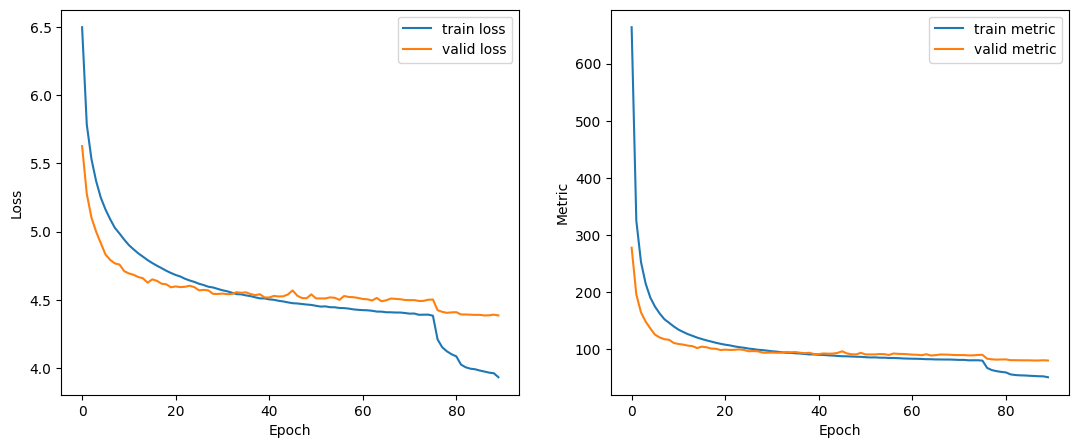

In [ ]:
plt.figure(figsize = (13, 5))
plt.subplot(1, 2, 1)
plt.plot(range(0, stop), train_loss_hist, label = 'train loss')
plt.plot(range(0, stop), valid_loss_hist, label = 'valid loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(range(0, stop), train_metric_hist, label = 'train metric')
plt.plot(range(0, stop), valid_metric_hist, label = 'valid metric')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.show()

In [ ]:
min(valid_metric_hist)

80.27452087402344

In [ ]:
from google.colab import files
files.download('best_model.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 🔵 **Test**

In [ ]:
model = torch.load('/content/best_model.pt').to(device)
torch.save(model.state_dict(), '/content/state_dict_model.pt')

In [ ]:
model.eval()
with torch.no_grad():
  _, _ = evaluate(model, test_loader, loss_func, metric, 20)

Loss : 4.345367908477783, Metric : 77.11455535888672


# 🔵 **Generate**

In [ ]:
def generate(prompt, max_seq_len, temperature, model, tokenizer, vocab, seed=None):
  tokenized_text = tokenizer(prompt)
  indexed_text   = torch.tensor([vocab[token] if token in vocab else vocab['<ukn>'] for token in tokenized_text])
  counter = 0
  generated_text = indexed_text
  max_seq_len    = max_seq_len - len(tokenized_text)
  while(counter<max_seq_len):
    with torch.no_grad():
      out, _ = model(generated_text.to(device))
      out = out[-1]

    out_softmax    = torch.nn.functional.softmax(out/temperature, dim = -1)
    multino_out    = torch.multinomial(torch.tensor(out_softmax), 1).item()

    if multino_out == vocab['<unk>']:
      None
    elif multino_out == vocab['.'] or counter == max_seq_len - 1:
      d = generated_text.tolist()
      d.append(vocab['.'])
      generated_text = torch.tensor(d)
      counter  = max_seq_len
    else:
      d = generated_text.tolist()
      d.append(multino_out)
      generated_text = torch.tensor(d)
      counter        += 1

  return ' '.join([vocab.get_itos()[index] if index in vocab.get_stoi().values() else '<not>' for index in generated_text.tolist()])

In [ ]:
text = 'i think this movie'
p = generate(text, 50, 0.6, model, tokenizer, vocabs)
p

<ipython-input-89-0d7e901e3d5a>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  multino_out    = torch.multinomial(torch.tensor(out_softmax), 1).item()


"i think this movie is the most beautiful thing i ' ve ever seen ."